In [2]:
import scipy.integrate as spi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyDOE import *
import pickle
import random
from matplotlib.pyplot import cm
import time

In [211]:
# Set model parameters: COVID example

delta_t = 5 ## time step (days)
end_t = 100 ## time horizon (days)

m = 4 ## number of population groups 

# d for distanced, n for non distanced population
alpha_n = [14,14,14,14] ## duration of infection for non distanced individuals 
alpha_d = [14,14,14,14] ## duration of infection for distanced individuals 
mu_n = [0.01,0.01,0.01,0.005] 
mu_d = [0.01,0.01,0.01,0.005]
f = [0.1,0.1,0.1,0.1]
theta = 1 ## 1-theta reduction in susceptibility 
phi = 0.25 ## 1-phi reduction in infectivity 

# Outcomes of interest
hosp = [0.47, 0.2, 0.16, 0.06]
ALOS = [12.7, 12.5, 12, 12.8]
ICU = [0.13, 0.08, 0.06, 0.02]
ICU_LOS = [12.8, 12.7, 12.5, 19.4]
vents = [0.45, 0.45, 0.40, 0.42] 
vent_days = [16, 14, 10, 23]
ECMO = [0.03, 0.05, 0.04, 0.1] 
ECMO_days = [15, 15, 12, 38] 

# Set initial population: 

# Susceptible: [Si_n, Si_d for i in range(m)]
initial_susceptible = [493800, 494500, 483924, 484610, 1037071, 692300, 4956288, 1240206] 
# Infected: [Ii_n, Ii_d for i in range(m)]
initial_infected = [700, 0, 686, 0, 1379, 0, 4536, 0]
# Recovered: [Ri_n, Ri_d for i in range(m)]
initial_recovered = [0] * 2*m
# Dead: [Di_n, Di_d for i in range(m)]
initial_dead = [0] * 2*m
## Create initial population vector: [S1_n, S1_d, ... Sm_n, Sm_d, I1_n, I1_d, ... R1_n, R1_d, .... D1_n, D1_d ...] 
initial_population = initial_susceptible + initial_infected + initial_recovered + initial_dead

# Next generation matrix for non-distanced individuals: (m * m)
R_n = np.array([[1.70, 0.2, 0.2, 0.02], 
                [0.07, 1.91, 0.07, 0.07], 
                [0.05, 0.05, 2.53, 0.05], 
                [0.01, 0.1, 0.1, 5.00]]).T
# Next generation matrix for distanced individuals: (m * m)
R_d = np.array([[1.70, 0.2, 0.2, 0.02], 
        [0.07, 1.91, 0.07, 0.07], 
        [0.05, 0.05, 2.53, 0.05], 
        [0.01, 0.1, 0.1, 5.00]]).T
# Contact matrix: 
C_n = (R_n/np.array(alpha_n)).T
C_d = (R_d/np.array(alpha_n)).T

t_max = 100000

In [102]:
# # Set model parameters: random example

# delta_t = 0.5 ## time step
# end_t = 100 ## time horizon

# m = 4 ## number of population groups 

# # d for distanced, n for non distanced population
# alpha_n = [1,2,3,4] ## duration of infection for non distanced individuals 
# alpha_d = [5,6,7,8] ## duration of infection for distanced individuals 
# mu_n = [0.01,0.02,0.03,0.04] 
# mu_d = [0.05,0.06,0.07,0.08] 
# f = [0.1,0.3,0.5,0.9]
# theta = 1 ## 1-theta reduction in susceptibility 
# phi = 0.25 ## 1-phi reduction in infectivity 

# # Outcomes of interest
# hosp = [0.47, 0.2, 0.16, 0.06]
# ALOS = [12.7, 12.5, 12, 12.8]
# ICU = [0.13, 0.08, 0.06, 0.02]
# ICU_LOS = [12.8, 12.7, 12.5, 19.4]
# vents = [0.45, 0.45, 0.40, 0.42] 
# vent_days = [16, 14, 10, 23]
# ECMO = [0.03, 0.05, 0.04, 0.1] 
# ECMO_days = [15, 15, 12, 38] 

# # Set initial population: 

# # Susceptible: [Si_n, Si_d for i in range(m)]
# initial_susceptible = [493800, 494500, 483924, 484610, 1037071, 692300, 4956288, 1240206] 
# # Infected: [Ii_n, Ii_d for i in range(m)]
# initial_infected = [700, 0, 686, 0, 1379, 0, 4536, 0]
# # Recovered: [Ri_n, Ri_d for i in range(m)]
# initial_recovered = [0] * 2*m
# # Dead: [Di_n, Di_d for i in range(m)]
# initial_dead = [0] * 2*m
# ## Create initial population vector: [S1_n, S1_d, ... Sm_n, Sm_d, I1_n, I1_d, ... R1_n, R1_d, .... D1_n, D1_d ...] 
# initial_population = initial_susceptible + initial_infected + initial_recovered + initial_dead

# # Next generation matrix for non-distanced individuals: (m * m)
# R_n = np.array([[1.70, 0.2, 0.2, 0.02], 
#                 [0.07, 1.91, 0.07, 0.07], 
#                 [0.05, 0.05, 2.53, 0.05], 
#                 [0.01, 0.1, 0.1, 5.00]]).T
# # Next generation matrix for distanced individuals: (m * m)
# R_d = np.array([[1.70, 0.2, 0.2, 0.02], 
#         [0.07, 1.91, 0.07, 0.07], 
#         [0.05, 0.05, 2.53, 0.05], 
#         [0.01, 0.1, 0.1, 5.00]]).T
# # Contact matrix: 
# C_n = (R_n/np.array(alpha_n)).T
# C_d = (R_d/np.array(alpha_n)).T

# t_max = 100000

## Deterministic model

In [212]:
# Define transitions
def deterministic(SIR_det): 
    # Create new columns: 
    # hospitalizations
    for i in range(m): 
        SIR_det[8*m+1+i] = (initial_infected[2*i]+initial_infected[2*i+1])*hosp[i]
    for i in range(m): 
        SIR_det[9*m+1+i] = SIR_det[8*m+1+i]
    # ICU
    for i in range(m):
        SIR_det[10*m+1+i] = (initial_infected[2*i]+initial_infected[2*i+1])*ICU[i]
    for i in range(m): 
        SIR_det[11*m+1+i] = SIR_det[10*m+1+i]
    # Vents
    for i in range(m):
        SIR_det[12*m+1+i] = (initial_infected[2*i]+initial_infected[2*i+1])*ICU[i]*vents[i]
    for i in range(m): 
        SIR_det[13*m+1+i] = SIR_det[12*m+1+i]
    # ECMO
    for i in range(m):
        SIR_det[14*m+1+i] = (initial_infected[2*i]+initial_infected[2*i+1])*ICU[i]*ECMO[i]
    for i in range(m): 
        SIR_det[15*m+1+i] = SIR_det[14*m+1+i]
    
    sum_t = 0
    t = 0
    while sum_t < end_t and t < t_max: 
        delta_t_temp = delta_t
        t += 1
        N = np.zeros(m)
        delta_Sn = np.zeros(m)
        delta_Sd = np.zeros(m)
        for i in range(m): 
            # at time t-1
            Sin = SIR_det.iloc[t-1,1+2*i]
            Sid = SIR_det.iloc[t-1,2+2*i]
            Iin = SIR_det.iloc[t-1,2*m+1+2*i]
            Iid = SIR_det.iloc[t-1,2*m+2+2*i]
            Rin = SIR_det.iloc[t-1,4*m+1+2*i]
            Rid = SIR_det.iloc[t-1,4*m+2+2*i]
            Din = SIR_det.iloc[t-1,6*m+1+2*i]
            Did = SIR_det.iloc[t-1,6*m+2+2*i]
            N[i] = Sin + Sid + Iin + Iid + Rin + Rid
            
            for j in range(m):
                Ijn = SIR_det.iloc[t-1,2*m+1+2*j]
                Ijd = SIR_det.iloc[t-1,2*m+2+2*j]
                delta_Sn[i] += -Sin/N[i]*C_n[j][i]*(Ijn + phi*Ijd)*delta_t_temp
                delta_Sd[i] += -theta*Sid/N[i]*C_d[j][i]*(Ijn + phi*Ijd)*delta_t_temp
            
            while Sin + delta_Sn[i] < 0 or Sid + delta_Sd[i] < 0 \
            or Iin - delta_Sn[i]*(1-f[i]) - Iin/alpha_n[i]*delta_t_temp < 0 \
            or Iid - delta_Sd[i] - delta_Sn[i]*f[i] - Iid/alpha_d[i]*delta_t_temp < 0: 
#                 print(Sin + delta_Sn[i])
#                 print(Sid + delta_Sd[i])
#                 print(Iin - delta_Sn[i]*(1-f[i]) - Iin/alpha[i]*delta_t_temp)
#                 print(Iid - delta_Sd[i] - delta_Sn[i]*f[i] - Iid/alpha[i]*delta_t_temp)
#                 print(sum_t)
#                 print(delta_t_temp)
                if delta_t_temp < 0.00001: 
                    return('delta_t_temp too small')
                delta_Sn = np.zeros(m)
                delta_Sd = np.zeros(m)
                delta_t_temp /= 2
                for j in range(m):
                    Ijn = SIR_det.iloc[t-1,2*m+1+2*j]
                    Ijd = SIR_det.iloc[t-1,2*m+2+2*j]
                    delta_Sn[i] += -Sin/N[i]*C_n[j][i]*(Ijn + phi*Ijd)*delta_t_temp
                    delta_Sd[i] += -theta*Sid/N[i]*C_d[j][i]*(Ijn + phi*Ijd)*delta_t_temp
            
            # Transition for Si_n
            SIR_det.iloc[t,1+2*i] = Sin + delta_Sn[i]
            # Transition for Si_d
            SIR_det.iloc[t,2+2*i] = Sid + delta_Sd[i] 
            # Transition for Ii_n 
            SIR_det.iloc[t,2*m+1+2*i] = Iin - delta_Sn[i]*(1-f[i]) - Iin/alpha_n[i]*delta_t_temp
            # Transition for Ii_d 
            SIR_det.iloc[t,2*m+2+2*i] = Iid - delta_Sd[i] - delta_Sn[i]*f[i] - Iid/alpha_d[i]*delta_t_temp
            # Transition for Ri_n 
            SIR_det.iloc[t,4*m+1+2*i] = Rin + Iin/alpha_n[i]*delta_t_temp*(1-mu_n[i])
            # Transition for Ri_d 
            SIR_det.iloc[t,4*m+2+2*i] = Rid + Iid/alpha_d[i]*delta_t_temp*(1-mu_d[i])
            # Transition for Di_n 
            SIR_det.iloc[t,6*m+1+2*i] = Din + Iin/alpha_n[i]*delta_t_temp*mu_n[i]
            # Transition for Di_d 
            SIR_det.iloc[t,6*m+2+2*i] = Did + Iid/alpha_d[i]*delta_t_temp*mu_d[i]

            if SIR_det.loc[t, 1+2*i] < 0 or SIR_det.loc[t, 2+2*i] < 0 or SIR_det.iloc[t,2*m+1+2*i] < 0 \
            or SIR_det.iloc[t,2*m+2+2*i] < 0: 
                return('Negative population size, error')
            
            # new hospitalizations
            SIR_det.iloc[t,8*m+1+i] = (SIR_det.iloc[t-1,1+2*i]+SIR_det.iloc[t-1,2+2*i] \
                                        -SIR_det.iloc[t,1+2*i]-SIR_det.iloc[t,2+2*i])\
                                        *hosp[i]
            # hospitalizations
            SIR_det.iloc[t,9*m+1+i] = SIR_det.iloc[t,8*m+1+i] + SIR_det.iloc[t-1,9*m+1+i]*(1-1/ALOS[i])
            # new ICU
            SIR_det.iloc[t,10*m+1+i] = (SIR_det.iloc[t-1,1+2*i]+SIR_det.iloc[t-1,2+2*i] \
                                        -SIR_det.iloc[t,1+2*i]-SIR_det.iloc[t,2+2*i])*ICU[i]
            # ICU
            SIR_det.iloc[t,11*m+1+i] = SIR_det.iloc[t,10*m+1+i] + SIR_det.iloc[t-1,11*m+1+i]*(1-1/ICU_LOS[i])
            # New vents
            SIR_det.iloc[t,12*m+1+i] = SIR_det.iloc[t,10*m+1+i]*vents[i]
            # Vents
            SIR_det.iloc[t,13*m+1+i] = SIR_det.iloc[t,12*m+1+i] + SIR_det.iloc[t-1,13*m+1+i]*(1-1/vent_days[i])
            # New ECMO
            SIR_det.iloc[t,14*m+1+i] = SIR_det.iloc[t,10*m+1+i]*ECMO[i]
            # ECMO
            SIR_det.iloc[t,15*m+1+i] = SIR_det.iloc[t,14*m+1+i] + SIR_det.iloc[t-1,15*m+1+i]*(1-1/ECMO_days[i])
            
        SIR_det.iloc[t,0] = SIR_det.iloc[t-1,0]+delta_t_temp 
        sum_t += delta_t_temp
    
    SIR_det = SIR_det.drop(SIR_det.iloc[:, np.r_[8*m+1:9*m+1,10*m+1:11*m+1,12*m+1:13*m+1,14*m+1:15*m+1]],axis = 1)
    
    SIR_det.columns = ['t'] \
                        + [item for pair in zip(['Susceptible Non Distanced'+' Group {}'.format(i+1) for i in range(m)], \
                            ['Susceptible Distanced'+' Group {}'.format(i+1) for i in range(m)]) for item in pair] \
                        + [item for pair in zip(['Infected Non Distanced'+' Group {}'.format(i+1) for i in range(m)], \
                            ['Infected Distanced'+' Group {}'.format(i+1) for i in range(m)]) for item in pair] \
                        + [item for pair in zip(['Recovered Non Distanced'+' Group {}'.format(i+1) for i in range(m)], \
                            ['Recovered Distanced'+' Group {}'.format(i+1) for i in range(m)]) for item in pair] \
                        + [item for pair in zip(['Dead Non Distanced'+' Group {}'.format(i+1) for i in range(m)], \
                            ['Dead Distanced'+' Group {}'.format(i+1) for i in range(m)]) for item in pair] \
                        + ['Hospitalization'+' Group {}'.format(i+1) for i in range(m)] \
                        + ['ICU'+' Group {}'.format(i+1) for i in range(m)] \
                        + ['Vents'+' Group {}'.format(i+1) for i in range(m)] \
                        + ['ECMO'+' Group {}'.format(i+1) for i in range(m)]
        
    return(SIR_det, t)


In [213]:
# Initialize the dataframe  
SIR_initial = pd.DataFrame({'t': np.zeros(t_max)}) ## time range
# Initialize population 
for i in range(1, 2*4*m+1):
    SIR_initial[i] = initial_population[i-1]

SIR_det, iterations = deterministic(SIR_initial)


In [214]:
SIR_det.iloc[0:iterations+1, :8*m+1]

,t,Susceptible Non Distanced Group 1,Susceptible Distanced Group 1,Susceptible Non Distanced Group 2,Susceptible Distanced Group 2,Susceptible Non Distanced Group 3,Susceptible Distanced Group 3,Susceptible Non Distanced Group 4,Susceptible Distanced Group 4,Infected Non Distanced Group 1,...,Recovered Non Distanced Group 4,Recovered Distanced Group 4,Dead Non Distanced Group 1,Dead Distanced Group 1,Dead Non Distanced Group 2,Dead Distanced Group 2,Dead Non Distanced Group 3,Dead Distanced Group 3,Dead Non Distanced Group 4,Dead Distanced Group 4
0,0.0,493800.000000,494500.000000,483924.000000,484610.000000,1.037071e+06,692300.000000,4.956288e+06,1.240206e+06,700.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5.0,493558.854343,494258.512500,483572.211188,484257.712500,1.036187e+06,691709.930000,4.949777e+06,1.238577e+06,667.031092,...,1.611900e+03,0.000000e+00,2.500000,0.000000,2.450000,0.000000,4.925000,0.000000,8.100000,0.000000
2,10.0,493292.808461,493992.089477,483072.218112,483757.010645,1.034941e+06,690878.376387,4.936407e+06,1.235231e+06,668.246996,...,4.730626e+03,8.103923e+02,4.882254,0.948579,5.155750,1.383809,10.932274,2.423082,23.771990,4.072323
3,15.0,492984.212594,493683.056152,482293.052384,482976.740388,1.033103e+06,689650.841909,4.909032e+06,1.228381e+06,707.323634,...,1.101152e+04,2.995336e+03,7.268850,2.604907,8.502281,4.240190,18.798045,7.395496,55.334288,15.051937
4,20.0,492598.769631,493297.066793,480970.928790,481652.742582,1.030234e+06,687736.021241,4.853267e+06,1.214427e+06,801.606718,...,2.380408e+04,7.806826e+03,9.795006,4.883592,13.158084,9.141387,29.765223,15.632833,119.618485,39.230280
5,25.0,492069.004056,492766.550234,478577.399279,479255.820055,1.025497e+06,684574.046174,4.740778e+06,1.186279e+06,992.107621,...,4.986281e+04,1.784027e+04,12.657887,7.864653,20.400783,17.492908,46.035462,28.791344,250.566877,89.649611
6,30.0,491262.360089,491958.762786,474072.040016,474744.074094,1.017278e+06,679087.407013,4.518342e+06,1.130619e+06,1363.763042,...,1.025912e+05,3.829029e+04,16.201129,11.864953,32.750291,32.277012,71.719894,50.234821,515.533622,192.413522
7,35.0,489923.638790,490618.143745,465486.852364,466146.716270,1.002541e+06,669249.618670,4.095977e+06,1.024932e+06,2081.553981,...,2.076277e+05,7.912027e+04,21.071711,17.609617,55.170773,59.503515,114.649625,86.550421,1043.355461,397.589280
8,40.0,487586.816190,488278.008517,449413.945350,450051.024657,9.759400e+05,651491.802791,3.357341e+06,8.401034e+05,3441.282185,...,4.102326e+05,1.579341e+05,28.505832,26.568655,97.179186,110.777254,189.616516,150.294368,2061.470594,793.638750
9,45.0,483496.514893,484181.908900,421046.638320,421643.504757,9.294196e+05,620436.999366,2.261931e+06,5.660004e+05,5893.524000,...,7.767104e+05,3.005281e+05,40.796126,41.520242,175.847509,206.963881,323.313862,264.193873,3903.067324,1510.191491


In [215]:
# rslt_df = SIR_det2[(SIR_det2['t'] != 0)] 
# rslt_df

# SIR_det2.iloc[0:iterations+1, 8*m+1:14*m+1]
SIR_det.iloc[0:iterations+1, 8*m+1:]

,Hospitalization Group 1,Hospitalization Group 2,Hospitalization Group 3,Hospitalization Group 4,ICU Group 1,ICU Group 2,ICU Group 3,ICU Group 4,Vents Group 1,Vents Group 2,Vents Group 3,Vents Group 4,ECMO Group 1,ECMO Group 2,ECMO Group 3,ECMO Group 4
0,329.000000,137.200000,220.640000,272.160000,91.000000,54.880000,82.740000,90.720000,40.950000,24.696000,33.096000,38.102400,2.730000,2.744000,3.309600,9.072000
1,529.932072,267.039262,438.093275,739.346442,146.632935,106.884845,164.560778,248.860025,66.624665,48.278747,65.162391,104.828626,4.430269,5.377372,6.571399,25.114895
2,738.465523,445.815108,733.941926,1684.516045,204.398195,178.524310,276.029575,570.342537,93.610054,80.855283,108.499616,240.681206,6.211547,9.021660,11.009129,57.885011
3,970.604351,722.037096,1163.402668,3606.349296,268.721381,289.222157,437.930672,1225.422126,123.890733,131.219601,171.243040,517.697855,8.206197,14.657960,17.451040,124.809590
4,1256.752003,1193.498408,1831.770448,7507.767872,348.013725,478.138470,689.890470,2556.644242,161.276353,217.107143,268.916436,1080.832298,10.667704,24.265248,27.476557,260.963948
5,1656.127755,2056.108943,2942.905198,15359.430740,458.661830,823.725935,1108.617590,5237.594201,213.223086,374.055763,431.592135,2215.188602,14.091624,41.809373,44.143578,535.370050
6,2284.506760,3695.041273,4890.570139,30845.212300,632.704959,1480.234043,1842.268323,10529.527481,294.340881,671.953282,717.368978,4454.879247,19.448465,75.090503,73.358552,1077.472601
7,3363.914298,6835.947066,8415.002605,60118.612651,931.589128,2738.283819,3169.379348,20547.829186,432.685986,1242.528256,1235.429077,8696.834403,28.601328,138.814651,126.225039,2105.224144
8,5297.209336,12722.791026,14811.219221,110829.712829,1466.813245,5096.158811,5577.379063,37957.951664,679.245145,2311.845789,2176.506194,16075.812519,44.934708,258.234735,222.168288,3896.752402
9,8727.714668,23059.933130,25988.974978,184341.897348,2416.450579,9236.872618,9785.697748,63391.608161,1115.696777,4190.607716,3820.659179,26880.769965,73.866024,468.118394,389.834625,6533.231480


## Stochastic model 

In [216]:
def stochastic(df_original): 
    df = df_original.copy()
    # Create new columns: 
    # hospitalizations
    for i in range(m): 
        df[8*m+1+i] = np.random.binomial(initial_infected[2*i]+initial_infected[2*i+1],hosp[i])
    for i in range(m): 
        df[9*m+1+i] = df[8*m+1+i]
    # ICU
    for i in range(m):
        df[10*m+1+i] = np.random.binomial(initial_infected[2*i]+initial_infected[2*i+1],ICU[i])
    for i in range(m): 
        df[11*m+1+i] = df[10*m+1+i]
    # Vents
    for i in range(m):
        df[12*m+1+i] = np.random.binomial(df[10*m+1+i][0],vents[i])
    for i in range(m): 
        df[13*m+1+i] = df[12*m+1+i]
    # ECMO
    for i in range(m):
        df[14*m+1+i] = np.random.binomial(df[10*m+1+i][0],ECMO[i])
    for i in range(m): 
        df[15*m+1+i] = df[14*m+1+i]
    
    sum_t = 0
    t = 0
    while sum_t < end_t and t < t_max: 
        delta_t_temp = delta_t
        t += 1
        N = np.zeros(m)
        p_n = np.zeros(m)
        p_d = np.zeros(m)
        delta_Sn = np.zeros(m)
        delta_Sd = np.zeros(m)
        delta_In = np.zeros(m)
        delta_Id = np.zeros(m)
        delta_Rn = np.zeros(m)
        delta_Rd = np.zeros(m)
        delta_Dn = np.zeros(m)
        delta_Dd = np.zeros(m)
        stay = np.zeros(m)
        for i in range(m): 
            # at time t-1
            Sin = df.iloc[t-1,1+2*i]
            Sid = df.iloc[t-1,2+2*i]
            Iin = df.iloc[t-1,2*m+1+2*i]
            Iid = df.iloc[t-1,2*m+2+2*i]
            Rin = df.iloc[t-1,4*m+1+2*i]
            Rid = df.iloc[t-1,4*m+2+2*i]
            Din = df.iloc[t-1,6*m+1+2*i]
            Did = df.iloc[t-1,6*m+2+2*i]
            N[i] = Sin + Sid + Iin + Iid + Rin + Rid
            for j in range(m):
                Ijn = df.iloc[t-1,2*m+1+2*j]
                Ijd = df.iloc[t-1,2*m+2+2*j]
                p_n[i] += C_n[j][i]*(Ijn + phi*Ijd)
                p_d[i] += C_d[j][i]*(Ijn + phi*Ijd)
                
            while 1/N[i]*p_n[i]*delta_t_temp < 0 or 1/N[i]*p_n[i]*delta_t_temp > 1 \
            or 1/N[i]*theta*p_d[i]*delta_t_temp < 0 or 1/N[i]*theta*p_d[i]*delta_t_temp > 1 \
            or 1/alpha_n[i]*delta_t_temp*(1-mu_n[i]) < 0 or 1/alpha_n[i]*delta_t_temp*(1-mu_n[i]) > 1 \
            or 1/alpha_d[i]*delta_t_temp*(1-mu_d[i]) < 0 or 1/alpha_d[i]*delta_t_temp*(1-mu_d[i]) > 1 \
            or 1/alpha_n[i]*delta_t_temp*mu_n[i] < 0 or 1/alpha_n[i]*delta_t_temp*mu_n[i] > 1 \
            or 1/alpha_d[i]*delta_t_temp*mu_d[i] < 0 or 1/alpha_d[i]*delta_t_temp*mu_d[i] > 1: 
                if delta_t_temp < 0.00001: 
                    return('delta_t_temp too small', t)
                delta_t_temp /= 2
#                 print(delta_t_temp)
#                 print(1/N[i]*p_n[i]*delta_t, 1/N[i]*theta*p_d[i]*delta_t, \
#                       1/alpha_n[i]*delta_t*(1-mu_n[i]), 1/alpha_d[i]*delta_t*(1-mu_d[i]),\
#                       1/alpha_n[i]*delta_t*mu_n[i], 1/alpha_d[i]*delta_t*mu_d[i])
                
            delta_Sn[i] = - np.random.binomial(Sin, 1/N[i]*p_n[i]*delta_t_temp)
            delta_Sd[i] = - np.random.binomial(Sid, 1/N[i]*theta*p_d[i]*delta_t_temp)
            delta_n = np.random.multinomial(Iin, [1-1/alpha_n[i]*delta_t_temp,\
                                                  1/alpha_n[i]*delta_t_temp*(1-mu_n[i]),\
                                                  1/alpha_n[i]*delta_t_temp*mu_n[i]]) 
            delta_In[i], delta_Rn[i], delta_Dn[i] = list(delta_n.flatten())
            delta_d = np.random.multinomial(Iid, [1-1/alpha_d[i]*delta_t_temp,\
                                                  1/alpha_d[i]*delta_t_temp*(1-mu_d[i]),\
                                                  1/alpha_d[i]*delta_t_temp*mu_d[i]]) 
            delta_Id[i], delta_Rd[i], delta_Dd[i] = list(delta_d.flatten())
            stay[i] = np.random.binomial(-delta_Sn[i], 1-f[i])

            # Transition for Si_n
            df.loc[t, 1+2*i] = Sin + delta_Sn[i]
            # Transition for Si_d
            df.loc[t, 2+2*i] = Sid + delta_Sd[i] 
            # Transition for Ii_n 
            df.iloc[t,2*m+1+2*i] = Iin + stay[i] - delta_Rn[i] - delta_Dn[i]
            # Transition for Ii_d 
            df.iloc[t,2*m+2+2*i] = Iid - delta_Sd[i] - delta_Sn[i] - stay[i] - delta_Rd[i] - delta_Dd[i]
            # Transition for Ri_n 
            df.iloc[t,4*m+1+2*i] = Rin + delta_Rn[i] 
            # Transition for Ri_d 
            df.iloc[t,4*m+2+2*i] = Rid + delta_Rd[i]
            # Transition for Di_n 
            df.iloc[t,6*m+1+2*i] = Din + delta_Dn[i] 
            # Transition for Di_d 
            df.iloc[t,6*m+2+2*i] = Did + delta_Dd[i] 
        
            # new hospitalizations
            df.iloc[t,8*m+1+i] = np.random.binomial(df.iloc[t-1,1+2*i]+df.iloc[t-1,2+2*i] \
                                        -df.iloc[t,1+2*i]-df.iloc[t,2+2*i], hosp[i])
            # hospitalizations
            df.iloc[t,9*m+1+i] = df.iloc[t,8*m+1+i] + np.random.binomial(df.iloc[t-1,9*m+1+i],1-1/ALOS[i])
            # new ICU
            df.iloc[t,10*m+1+i] = np.random.binomial(df.iloc[t-1,1+2*i]+df.iloc[t-1,2+2*i] \
                                        -df.iloc[t,1+2*i]-df.iloc[t,2+2*i], ICU[i])
            # ICU
            df.iloc[t,11*m+1+i] = df.iloc[t,10*m+1+i] + np.random.binomial(df.iloc[t-1,11*m+1+i],1-1/ICU_LOS[i])
            # New vents
            df.iloc[t,12*m+1+i] = np.random.binomial(df.iloc[t,10*m+1+i],vents[i])
            # Vents
            df.iloc[t,13*m+1+i] = df.iloc[t,12*m+1+i] + np.random.binomial(df.iloc[t-1,13*m+1+i],1-1/vent_days[i])
            # New ECMO
            df.iloc[t,14*m+1+i] = np.random.binomial(df.iloc[t,10*m+1+i],ECMO[i])
            # ECMO
            df.iloc[t,15*m+1+i] = df.iloc[t,14*m+1+i] + np.random.binomial(df.iloc[t-1,15*m+1+i],1-1/ECMO_days[i])
            
        df.iloc[t,0] = df.iloc[t-1,0]+delta_t_temp 
        sum_t += delta_t_temp
        
    # add columns at the end which calculate number of infections and deaths per group 
    for i in range(m): 
        df[16*m+1+i] = df[2*m+1+2*i]+df[2*m+2+2*i] ## Iin + Iid
    for i in range(m): 
        df[17*m+1+i] = df[6*m+1+2*i]+df[6*m+2+2*i] ## Din + Did 
    
    df = df.drop(df.iloc[:, np.r_[8*m+1:9*m+1,10*m+1:11*m+1,12*m+1:13*m+1,14*m+1:15*m+1]],axis = 1)

    df.columns = ['t'] \
                        + [item for pair in zip(['Susceptible Non Distanced'+' Group {}'.format(i+1) for i in range(m)], \
                            ['Susceptible Distanced'+' Group {}'.format(i+1) for i in range(m)]) for item in pair] \
                        + [item for pair in zip(['Infected Non Distanced'+' Group {}'.format(i+1) for i in range(m)], \
                            ['Infected Distanced'+' Group {}'.format(i+1) for i in range(m)]) for item in pair] \
                        + [item for pair in zip(['Recovered Non Distanced'+' Group {}'.format(i+1) for i in range(m)], \
                            ['Recovered Distanced'+' Group {}'.format(i+1) for i in range(m)]) for item in pair] \
                        + [item for pair in zip(['Dead Non Distanced'+' Group {}'.format(i+1) for i in range(m)], \
                            ['Dead Distanced'+' Group {}'.format(i+1) for i in range(m)]) for item in pair] \
                        + ['Hospitalization'+' Group {}'.format(i+1) for i in range(m)] \
                        + ['ICU'+' Group {}'.format(i+1) for i in range(m)] \
                        + ['Vents'+' Group {}'.format(i+1) for i in range(m)] \
                        + ['ECMO'+' Group {}'.format(i+1) for i in range(m)] \
                        + ['Total Infections'+' Group {}'.format(i+1) for i in range(m)]\
                        + ['Total Deaths'+' Group {}'.format(i+1) for i in range(m)]
    
    return(df, t)


In [217]:
# delta_t = 10

# Initialize the dataframe  
SIR_initial = pd.DataFrame({'t': np.zeros(t_max)}) ## time range
# Initialize population 
for i in range(1, 2*4*m+1):
    SIR_initial[i] = initial_population[i-1]

SIR_stoch1, t = stochastic(SIR_initial)

SIR_stoch2, t = stochastic(SIR_initial)

SIR_stoch1.equals(SIR_stoch2)

False

In [218]:
SIR_stoch1.iloc[0:iterations+1, :]

,t,Susceptible Non Distanced Group 1,Susceptible Distanced Group 1,Susceptible Non Distanced Group 2,Susceptible Distanced Group 2,Susceptible Non Distanced Group 3,Susceptible Distanced Group 3,Susceptible Non Distanced Group 4,Susceptible Distanced Group 4,Infected Non Distanced Group 1,...,ECMO Group 3,ECMO Group 4,Total Infections Group 1,Total Infections Group 2,Total Infections Group 3,Total Infections Group 4,Total Deaths Group 1,Total Deaths Group 2,Total Deaths Group 3,Total Deaths Group 4
0,0.0,493800.0,494500.0,483924.0,484610.0,1037071.0,692300.0,4956288.0,1240206.0,700.0,...,3,9,700.0,686.0,1379.0,4536.0,0.0,0.0,0.0,0.0
1,5.0,493559.0,494253.0,483546.0,484254.0,1036190.0,691743.0,4949765.0,1238591.0,661.0,...,6,27,927.0,1164.0,2307.0,11026.0,0.0,0.0,7.0,9.0
2,10.0,493298.0,493980.0,483036.0,483753.0,1035004.0,690972.0,4936359.0,1235290.0,674.0,...,10,59,1138.0,1780.0,3425.0,23720.0,3.0,6.0,14.0,30.0
3,15.0,493017.0,493648.0,482291.0,482975.0,1033158.0,689760.0,4908875.0,1228470.0,680.0,...,18,131,1332.0,2652.0,5204.0,49627.0,8.0,8.0,24.0,75.0
4,20.0,492611.0,493262.0,480886.0,481604.0,1030304.0,687896.0,4852650.0,1214491.0,808.0,...,25,267,1640.0,4453.0,8067.0,102084.0,10.0,14.0,45.0,163.0
5,25.0,492055.0,492695.0,478488.0,479176.0,1025538.0,684730.0,4739766.0,1186255.0,1028.0,...,43,572,2197.0,7704.0,13038.0,206860.0,14.0,29.0,75.0,367.0
6,30.0,491156.0,491834.0,474023.0,474657.0,1017190.0,679340.0,4515745.0,1130227.0,1487.0,...,73,1111,3168.0,13925.0,22172.0,413053.0,18.0,45.0,115.0,749.0
7,35.0,489748.0,490472.0,465308.0,466102.0,1002671.0,669345.0,4091175.0,1024085.0,2224.0,...,125,2137,4804.0,26265.0,38769.0,796493.0,30.0,94.0,201.0,1491.0
8,40.0,487290.0,488009.0,448946.0,449944.0,976348.0,651678.0,3348853.0,838523.0,3630.0,...,223,3943,8011.0,49399.0,68904.0,1440601.0,48.0,196.0,338.0,2896.0
9,45.0,483205.0,483866.0,420402.0,421382.0,930081.0,620537.0,2250417.0,563007.0,6066.0,...,368,6592,13422.0,88762.0,121677.0,2300502.0,73.0,381.0,598.0,5428.0


In [219]:
SIR_stoch2.iloc[0:iterations+1, :]

,t,Susceptible Non Distanced Group 1,Susceptible Distanced Group 1,Susceptible Non Distanced Group 2,Susceptible Distanced Group 2,Susceptible Non Distanced Group 3,Susceptible Distanced Group 3,Susceptible Non Distanced Group 4,Susceptible Distanced Group 4,Infected Non Distanced Group 1,...,ECMO Group 3,ECMO Group 4,Total Infections Group 1,Total Infections Group 2,Total Infections Group 3,Total Infections Group 4,Total Deaths Group 1,Total Deaths Group 2,Total Deaths Group 3,Total Deaths Group 4
0,0.0,493800.0,494500.0,483924.0,484610.0,1037071.0,692300.0,4956288.0,1240206.0,700.0,...,7,11,700.0,686.0,1379.0,4536.0,0.0,0.0,0.0,0.0
1,5.0,493576.0,494251.0,483577.0,484255.0,1036205.0,691701.0,4949808.0,1238537.0,663.0,...,9,26,933.0,1156.0,2329.0,11074.0,1.0,2.0,4.0,6.0
2,10.0,493310.0,493961.0,483123.0,483722.0,1034956.0,690876.0,4936466.0,1235174.0,686.0,...,10,51,1190.0,1731.0,3567.0,23916.0,4.0,8.0,13.0,29.0
3,15.0,493003.0,493621.0,482394.0,482938.0,1033236.0,689686.0,4909265.0,1228386.0,697.0,...,20,117,1357.0,2606.0,5231.0,49426.0,9.0,14.0,29.0,71.0
4,20.0,492624.0,493241.0,481132.0,481554.0,1030435.0,687816.0,4853652.0,1214578.0,822.0,...,30,272,1666.0,4328.0,8100.0,101284.0,15.0,21.0,45.0,154.0
5,25.0,492057.0,492672.0,478727.0,479223.0,1025662.0,684694.0,4741133.0,1186721.0,1042.0,...,43,541,2179.0,7525.0,13066.0,205791.0,21.0,35.0,77.0,326.0
6,30.0,491276.0,491811.0,474207.0,474662.0,1017400.0,679327.0,4519435.0,1131296.0,1378.0,...,65,1063,3075.0,13966.0,21998.0,409166.0,34.0,63.0,123.0,678.0
7,35.0,490000.0,490446.0,465645.0,465997.0,1002722.0,669513.0,4098446.0,1025249.0,2074.0,...,124,2153,4656.0,26193.0,38645.0,790365.0,51.0,121.0,220.0,1394.0
8,40.0,487680.0,488097.0,449580.0,449922.0,975829.0,651861.0,3362545.0,840628.0,3392.0,...,242,3932,7628.0,49007.0,69364.0,1428624.0,67.0,209.0,368.0,2805.0
9,45.0,483553.0,484077.0,421172.0,421727.0,929493.0,620703.0,2270179.0,567944.0,5907.0,...,398,6543,13077.0,88051.0,122006.0,2283121.0,93.0,406.0,609.0,5390.0


In [221]:
# Simulate multiple stochastic models

# Initialize the dataframe  
SIR_initial = pd.DataFrame({'t': np.zeros(t_max)}) ## time range
# Initialize population 
for i in range(1, 2*4*m+1):
    SIR_initial[i] = initial_population[i-1]

# Define number of iterations

n_iter = 1000

dataset = []
for i in range(n_iter):
    SIR_stoch, t = stochastic(SIR_initial)
    dataset.append(SIR_stoch.iloc[0:iterations+1, :])
final_dataset = pd.concat(dataset)


In [222]:
final_dataset[0:50]

,t,Susceptible Non Distanced Group 1,Susceptible Distanced Group 1,Susceptible Non Distanced Group 2,Susceptible Distanced Group 2,Susceptible Non Distanced Group 3,Susceptible Distanced Group 3,Susceptible Non Distanced Group 4,Susceptible Distanced Group 4,Infected Non Distanced Group 1,...,ECMO Group 3,ECMO Group 4,Total Infections Group 1,Total Infections Group 2,Total Infections Group 3,Total Infections Group 4,Total Deaths Group 1,Total Deaths Group 2,Total Deaths Group 3,Total Deaths Group 4
0,0.0,493800.0,494500.0,483924.0,484610.0,1037071.0,692300.0,4956288.0,1240206.0,700.0,...,6,8,700.0,686.0,1379.0,4536.0,0.0,0.0,0.0,0.0
1,5.0,493516.0,494239.0,483560.0,484259.0,1036159.0,691742.0,4949785.0,1238545.0,688.0,...,11,23,981.0,1152.0,2352.0,11072.0,3.0,3.0,5.0,6.0
2,10.0,493265.0,493950.0,483049.0,483741.0,1034892.0,690852.0,4936520.0,1235199.0,674.0,...,15,60,1168.0,1801.0,3672.0,23816.0,10.0,10.0,13.0,18.0
3,15.0,492927.0,493643.0,482236.0,482935.0,1033054.0,689613.0,4909104.0,1228327.0,752.0,...,17,130,1383.0,2765.0,5435.0,49596.0,14.0,16.0,26.0,56.0
4,20.0,492546.0,493236.0,480898.0,481640.0,1030191.0,687643.0,4853113.0,1214429.0,823.0,...,28,260,1665.0,4403.0,8303.0,101710.0,19.0,25.0,44.0,153.0
5,25.0,492020.0,492726.0,478499.0,479228.0,1025552.0,684473.0,4740683.0,1186333.0,991.0,...,45,554,2090.0,7614.0,13192.0,205803.0,27.0,45.0,72.0,336.0
6,30.0,491210.0,491920.0,473992.0,474758.0,1017562.0,679003.0,4518038.0,1130754.0,1337.0,...,70,1052,2933.0,13814.0,21878.0,410474.0,35.0,73.0,129.0,693.0
7,35.0,489893.0,490564.0,465406.0,466145.0,1002962.0,669277.0,4096331.0,1024654.0,2040.0,...,124,2085,4601.0,26061.0,38422.0,791949.0,42.0,127.0,210.0,1378.0
8,40.0,487530.0,488223.0,449607.0,450118.0,976545.0,651569.0,3357978.0,839812.0,3434.0,...,232,3900,7656.0,48594.0,68743.0,1432359.0,58.0,225.0,346.0,2770.0
9,45.0,483460.0,484237.0,421226.0,421808.0,929709.0,620696.0,2262228.0,566172.0,5888.0,...,404,6456,13071.0,87907.0,122101.0,2289940.0,83.0,410.0,590.0,5207.0


In [223]:
# # Check that datasets are changing 

# for i in range(n_iter): 
#     print(dataset[0].equals(dataset[i]))

In [224]:
dataset[0]

,t,Susceptible Non Distanced Group 1,Susceptible Distanced Group 1,Susceptible Non Distanced Group 2,Susceptible Distanced Group 2,Susceptible Non Distanced Group 3,Susceptible Distanced Group 3,Susceptible Non Distanced Group 4,Susceptible Distanced Group 4,Infected Non Distanced Group 1,...,ECMO Group 3,ECMO Group 4,Total Infections Group 1,Total Infections Group 2,Total Infections Group 3,Total Infections Group 4,Total Deaths Group 1,Total Deaths Group 2,Total Deaths Group 3,Total Deaths Group 4
0,0.0,493800.0,494500.0,483924.0,484610.0,1037071.0,692300.0,4956288.0,1240206.0,700.0,...,6,8,700.0,686.0,1379.0,4536.0,0.0,0.0,0.0,0.0
1,5.0,493516.0,494239.0,483560.0,484259.0,1036159.0,691742.0,4949785.0,1238545.0,688.0,...,11,23,981.0,1152.0,2352.0,11072.0,3.0,3.0,5.0,6.0
2,10.0,493265.0,493950.0,483049.0,483741.0,1034892.0,690852.0,4936520.0,1235199.0,674.0,...,15,60,1168.0,1801.0,3672.0,23816.0,10.0,10.0,13.0,18.0
3,15.0,492927.0,493643.0,482236.0,482935.0,1033054.0,689613.0,4909104.0,1228327.0,752.0,...,17,130,1383.0,2765.0,5435.0,49596.0,14.0,16.0,26.0,56.0
4,20.0,492546.0,493236.0,480898.0,481640.0,1030191.0,687643.0,4853113.0,1214429.0,823.0,...,28,260,1665.0,4403.0,8303.0,101710.0,19.0,25.0,44.0,153.0
5,25.0,492020.0,492726.0,478499.0,479228.0,1025552.0,684473.0,4740683.0,1186333.0,991.0,...,45,554,2090.0,7614.0,13192.0,205803.0,27.0,45.0,72.0,336.0
6,30.0,491210.0,491920.0,473992.0,474758.0,1017562.0,679003.0,4518038.0,1130754.0,1337.0,...,70,1052,2933.0,13814.0,21878.0,410474.0,35.0,73.0,129.0,693.0
7,35.0,489893.0,490564.0,465406.0,466145.0,1002962.0,669277.0,4096331.0,1024654.0,2040.0,...,124,2085,4601.0,26061.0,38422.0,791949.0,42.0,127.0,210.0,1378.0
8,40.0,487530.0,488223.0,449607.0,450118.0,976545.0,651569.0,3357978.0,839812.0,3434.0,...,232,3900,7656.0,48594.0,68743.0,1432359.0,58.0,225.0,346.0,2770.0
9,45.0,483460.0,484237.0,421226.0,421808.0,929709.0,620696.0,2262228.0,566172.0,5888.0,...,404,6456,13071.0,87907.0,122101.0,2289940.0,83.0,410.0,590.0,5207.0


In [225]:
dataset[1]

,t,Susceptible Non Distanced Group 1,Susceptible Distanced Group 1,Susceptible Non Distanced Group 2,Susceptible Distanced Group 2,Susceptible Non Distanced Group 3,Susceptible Distanced Group 3,Susceptible Non Distanced Group 4,Susceptible Distanced Group 4,Infected Non Distanced Group 1,...,ECMO Group 3,ECMO Group 4,Total Infections Group 1,Total Infections Group 2,Total Infections Group 3,Total Infections Group 4,Total Deaths Group 1,Total Deaths Group 2,Total Deaths Group 3,Total Deaths Group 4
0,0.0,493800.0,494500.0,483924.0,484610.0,1037071.0,692300.0,4956288.0,1240206.0,700.0,...,2,5,700.0,686.0,1379.0,4536.0,0.0,0.0,0.0,0.0
1,5.0,493553.0,494245.0,483593.0,484260.0,1036186.0,691695.0,4949807.0,1238592.0,680.0,...,5,29,959.0,1153.0,2387.0,11022.0,0.0,1.0,7.0,8.0
2,10.0,493295.0,493996.0,483042.0,483766.0,1034884.0,690924.0,4936535.0,1235293.0,653.0,...,9,64,1110.0,1803.0,3631.0,23672.0,5.0,6.0,16.0,24.0
3,15.0,492997.0,493728.0,482235.0,482972.0,1032991.0,689662.0,4909198.0,1228447.0,667.0,...,13,133,1266.0,2740.0,5475.0,49311.0,10.0,13.0,27.0,63.0
4,20.0,492638.0,493368.0,480898.0,481618.0,1030078.0,687816.0,4853521.0,1214680.0,745.0,...,22,284,1524.0,4448.0,8260.0,101211.0,17.0,26.0,50.0,158.0
5,25.0,492126.0,492824.0,478421.0,479185.0,1025301.0,684671.0,4741289.0,1186220.0,972.0,...,39,577,2093.0,7732.0,13183.0,205668.0,20.0,45.0,83.0,344.0
6,30.0,491357.0,492006.0,473737.0,474625.0,1016993.0,679132.0,4518880.0,1130776.0,1315.0,...,63,1081,2915.0,14259.0,22291.0,409689.0,29.0,83.0,141.0,725.0
7,35.0,489989.0,490696.0,464967.0,465944.0,1002188.0,669354.0,4097428.0,1025638.0,2097.0,...,103,2119,4591.0,26637.0,38932.0,790222.0,43.0,148.0,211.0,1507.0
8,40.0,487681.0,488382.0,448841.0,449836.0,975543.0,651371.0,3359421.0,841086.0,3426.0,...,194,3959,7543.0,49292.0,69759.0,1431311.0,67.0,246.0,339.0,2984.0
9,45.0,483628.0,484198.0,420458.0,421323.0,928799.0,620181.0,2264194.0,566964.0,5867.0,...,360,6518,13109.0,88508.0,122695.0,2288887.0,93.0,419.0,605.0,5504.0


In [226]:
# by_iteration_index = final_dataset.groupby(final_dataset.index)
# df_means = by_iteration_index.mean()
# df_std = by_iteration_index.agg(np.std)

grouped = final_dataset.groupby(['t'], as_index=False)

df_means = grouped.mean()
df_std = grouped.agg(np.std)

In [227]:
df_means.head()

,t,Susceptible Non Distanced Group 1,Susceptible Distanced Group 1,Susceptible Non Distanced Group 2,Susceptible Distanced Group 2,Susceptible Non Distanced Group 3,Susceptible Distanced Group 3,Susceptible Non Distanced Group 4,Susceptible Distanced Group 4,Infected Non Distanced Group 1,...,ECMO Group 3,ECMO Group 4,Total Infections Group 1,Total Infections Group 2,Total Infections Group 3,Total Infections Group 4,Total Deaths Group 1,Total Deaths Group 2,Total Deaths Group 3,Total Deaths Group 4
0,0.0,493800.000,494500.000,483924.000,484610.000,1037071.000,692300.000,4956288.000,1240206.000,700.000,...,3.466,8.962,700.000,686.000,1379.000,4536.000,0.000,0.000,0.000,0.000
1,5.0,493559.198,494257.832,483572.081,484257.669,1036188.246,691708.736,4949775.575,1238575.272,667.155,...,6.742,25.057,933.220,1145.012,2361.186,11059.777,2.529,2.550,4.905,8.161
2,10.0,493292.475,493992.182,483072.278,483756.817,1034943.881,690879.710,4936408.979,1235227.234,669.325,...,11.057,57.818,1132.300,1736.507,3593.597,23825.580,5.957,6.698,13.276,27.771
3,15.0,492983.676,493683.288,482293.348,482976.365,1033106.501,689651.645,4909035.476,1228375.581,708.286,...,17.527,124.669,1346.045,2675.831,5375.305,49542.550,10.040,12.712,26.313,70.250
4,20.0,492598.610,493297.318,480971.876,481652.879,1030239.792,687738.673,4853256.017,1214421.509,802.317,...,27.431,260.014,1636.830,4365.796,8235.408,101582.679,14.797,22.399,45.515,158.737


In [228]:
df_means.tail()

,t,Susceptible Non Distanced Group 1,Susceptible Distanced Group 1,Susceptible Non Distanced Group 2,Susceptible Distanced Group 2,Susceptible Non Distanced Group 3,Susceptible Distanced Group 3,Susceptible Non Distanced Group 4,Susceptible Distanced Group 4,Infected Non Distanced Group 1,...,ECMO Group 3,ECMO Group 4,Total Infections Group 1,Total Infections Group 2,Total Infections Group 3,Total Infections Group 4,Total Deaths Group 1,Total Deaths Group 2,Total Deaths Group 3,Total Deaths Group 4
16,80.0,395528.882,396079.369,145980.964,146193.396,312488.182,208601.811,30231.392,7562.388,34418.916,...,2099.816,10268.220,76545.518,158370.797,345462.762,401785.570,1209.673,5185.385,8642.666,28808.042
17,85.0,381602.069,382134.086,133560.786,133753.273,272331.146,181799.483,27417.704,6859.126,34661.955,...,2086.277,10005.484,77077.712,126660.540,289023.192,261805.504,1483.687,5751.079,9877.769,29525.840
18,90.0,368671.082,369194.562,124585.913,124770.513,243296.854,162413.346,25750.744,6442.063,33922.572,...,2028.089,9746.097,75422.158,99383.386,234232.136,170405.866,1759.206,6203.433,10909.494,29993.774
19,95.0,356879.524,357389.092,118049.972,118227.731,222351.308,148436.760,24728.854,6187.352,32421.313,...,1942.763,9491.609,72085.069,76967.097,185501.831,110827.464,2028.479,6558.952,11745.697,30299.094
20,100.0,346277.368,346770.697,113250.235,113416.618,207211.283,138330.047,24088.534,6027.479,30387.624,...,1840.675,9243.340,67562.450,59089.071,144492.560,72055.588,2286.520,6834.372,12407.690,30498.442


In [229]:
df_std.head()

,t,Susceptible Non Distanced Group 1,Susceptible Distanced Group 1,Susceptible Non Distanced Group 2,Susceptible Distanced Group 2,Susceptible Non Distanced Group 3,Susceptible Distanced Group 3,Susceptible Non Distanced Group 4,Susceptible Distanced Group 4,Infected Non Distanced Group 1,...,ECMO Group 3,ECMO Group 4,Total Infections Group 1,Total Infections Group 2,Total Infections Group 3,Total Infections Group 4,Total Deaths Group 1,Total Deaths Group 2,Total Deaths Group 3,Total Deaths Group 4
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.835269,2.939591,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5.0,15.913203,16.073398,18.953302,18.145763,28.942030,25.072034,81.235408,40.036995,19.834172,...,2.686755,4.931132,26.457127,29.692415,42.593634,96.971185,1.540627,1.614964,2.192437,2.833921
2,10.0,26.148138,25.424817,33.440739,30.430372,57.081460,41.707498,224.890676,78.310892,26.465067,...,3.464355,7.369069,39.798869,48.075058,77.402272,246.824423,2.413084,2.530850,3.742704,5.094754
3,15.0,37.929588,34.336133,52.438962,48.630738,98.273484,65.425679,527.367585,150.734091,31.988145,...,4.312989,11.147273,50.245334,73.633228,120.303121,553.077720,3.144883,3.561986,5.107555,8.444810
4,20.0,50.693291,46.557131,75.948409,70.515948,152.649502,96.570274,1166.211381,308.909146,38.132829,...,5.324057,16.202664,62.857507,97.859414,174.111741,1164.568546,3.825235,4.693594,6.746354,12.882616


In [230]:
df_std.tail()

,t,Susceptible Non Distanced Group 1,Susceptible Distanced Group 1,Susceptible Non Distanced Group 2,Susceptible Distanced Group 2,Susceptible Non Distanced Group 3,Susceptible Distanced Group 3,Susceptible Non Distanced Group 4,Susceptible Distanced Group 4,Infected Non Distanced Group 1,...,ECMO Group 3,ECMO Group 4,Total Infections Group 1,Total Infections Group 2,Total Infections Group 3,Total Infections Group 4,Total Deaths Group 1,Total Deaths Group 2,Total Deaths Group 3,Total Deaths Group 4
16,80.0,593.789614,517.808844,503.140248,459.808742,1258.975320,801.129009,215.620933,94.196212,248.050487,...,45.014781,96.467817,430.687122,702.292350,1175.989218,2968.511934,34.288829,68.829138,94.293508,174.390344
17,85.0,629.866060,549.103696,467.977920,420.473976,1057.598932,675.124717,197.842680,88.179270,253.375994,...,45.368277,95.579188,433.776942,640.736001,1201.326446,1983.168746,37.956524,71.925823,100.540041,176.474382
18,90.0,660.911908,570.633694,446.154708,396.187279,920.525614,585.899208,187.077327,84.613536,252.773300,...,45.567636,94.755613,443.279842,547.212976,1124.545508,1328.695065,41.186477,75.995795,106.010500,178.363871
19,95.0,695.222852,595.603260,426.273408,380.664393,812.005029,527.431150,180.824341,82.368104,252.702401,...,44.887322,92.620422,450.478525,458.863881,993.071248,884.218049,45.002119,79.136985,108.535161,179.003087
20,100.0,723.426765,615.534682,415.014118,368.128647,741.295837,488.430379,176.377651,81.290564,252.185904,...,43.362445,90.851540,447.918558,380.339762,840.919147,612.576655,48.818571,81.187037,111.706563,179.230707


# Plots

## Deterministic

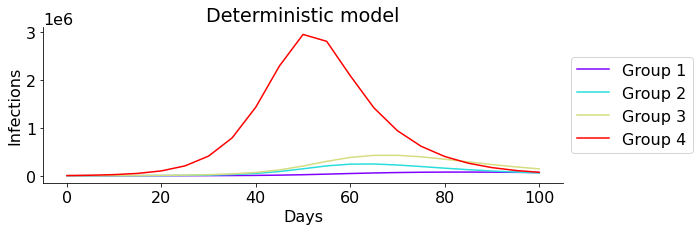

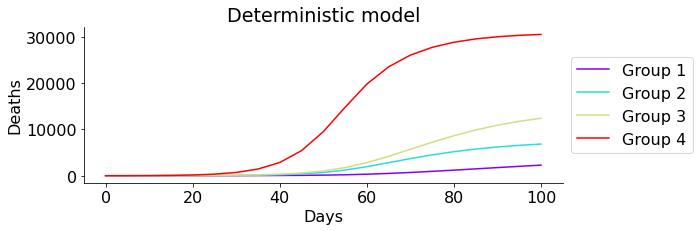

In [231]:
color = cm.rainbow(np.linspace(0, 1, m))

# Infections by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color):
    ax.plot(SIR_det.iloc[0:iterations+1,0], SIR_det.iloc[0:iterations+1,2*m+1+2*i]\
                    +SIR_det.iloc[0:iterations+1,2*m+2+2*i], c=c, label = f'Group {i+1}')
ax.set_xlabel('Days')
ax.set_ylabel('Infections')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Deterministic model')
plt.tight_layout()
plt.show()

# Deaths by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color): 
    ax.plot(SIR_det.iloc[0:iterations+1,0], SIR_det.iloc[0:iterations+1,6*m+1+2*i]\
                    +SIR_det.iloc[0:iterations+1,6*m+2+2*i], c=c, label = f'Group {i+1}')
ax.set_xlabel('Days')
ax.set_ylabel('Deaths')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Deterministic model')
plt.tight_layout()
plt.show()


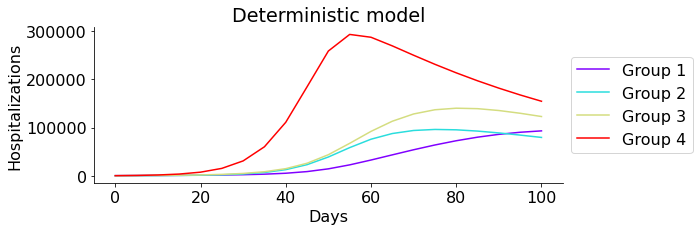

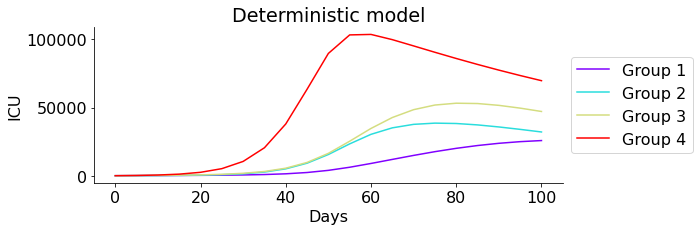

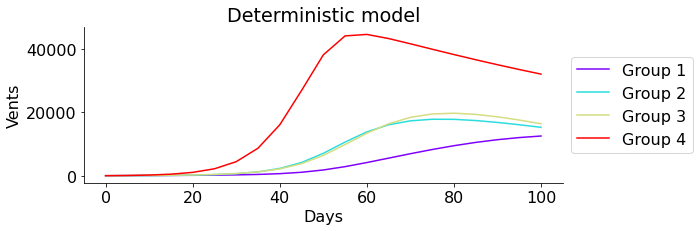

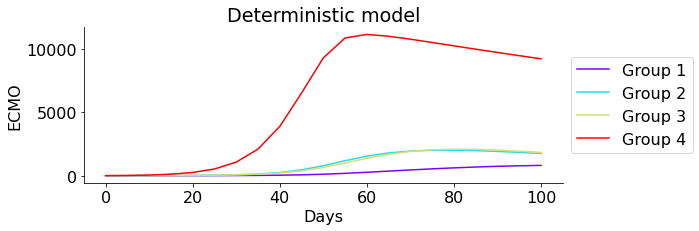

In [232]:
color = cm.rainbow(np.linspace(0, 1, m))

# Hospitalizations by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color):
    ax.plot(SIR_det.iloc[0:iterations+1,0], SIR_det.iloc[0:iterations+1,8*m+1+i], c=c, label = f'Group {i+1}')
ax.set_xlabel('Days')
ax.set_ylabel('Hospitalizations')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Deterministic model')
plt.tight_layout()
plt.show()

# ICU by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color):
    ax.plot(SIR_det.iloc[0:iterations+1,0], SIR_det.iloc[0:iterations+1,9*m+1+i], c=c, label = f'Group {i+1}')
ax.set_xlabel('Days')
ax.set_ylabel('ICU')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Deterministic model')
plt.tight_layout()
plt.show()

# Vents by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color):
    ax.plot(SIR_det.iloc[0:iterations+1,0], SIR_det.iloc[0:iterations+1,10*m+1+i], c=c, label = f'Group {i+1}')
ax.set_xlabel('Days')
ax.set_ylabel('Vents')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Deterministic model')
plt.tight_layout()
plt.show()

# ECMO by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color):
    ax.plot(SIR_det.iloc[0:iterations+1,0], SIR_det.iloc[0:iterations+1,11*m+1+i], c=c, label = f'Group {i+1}')
ax.set_xlabel('Days')
ax.set_ylabel('ECMO')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Deterministic model')
plt.tight_layout()
plt.show()



## Stochastic

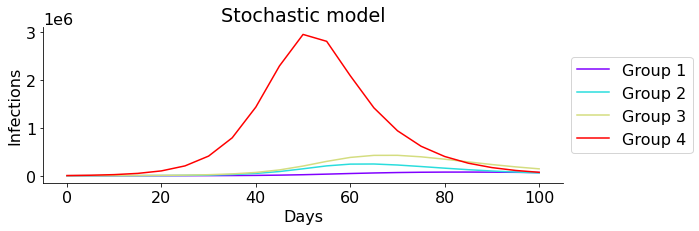

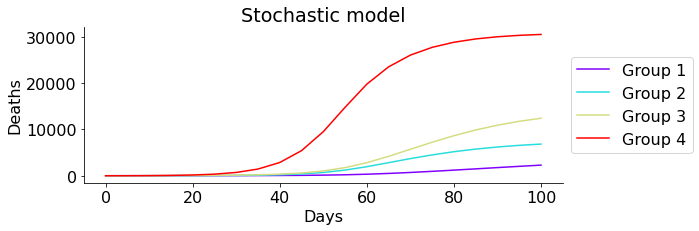

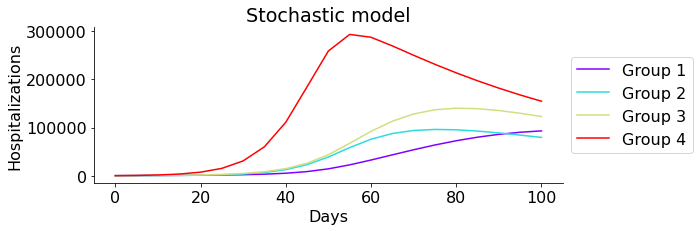

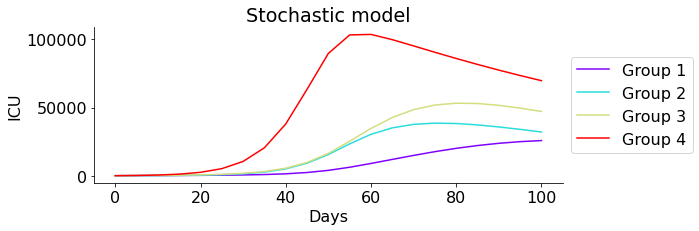

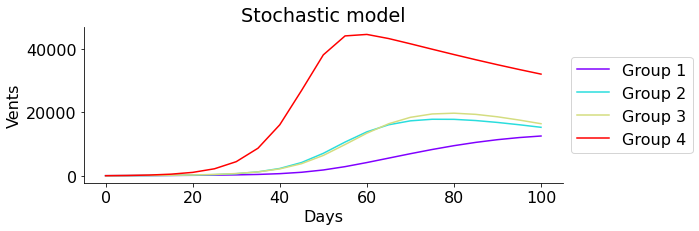

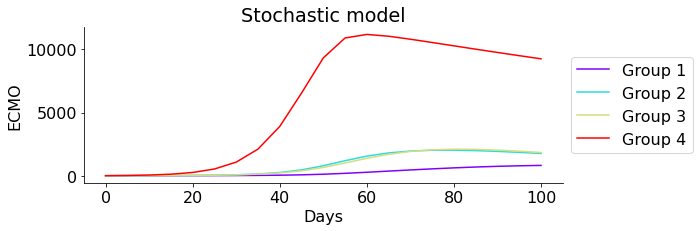

In [233]:
# Means

color = cm.rainbow(np.linspace(0, 1, m))

# Infections by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color):
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,2*m+1+2*i]+df_means.iloc[:,2*m+2+2*i], c=c, label = f'Group {i+1}')
#     ax.plot(np.arange(0,  end_t+delta_t, delta_t), df_means[8*m+1+i], c=c, label = f'Group {i+1}')
ax.set_xlabel('Days')
ax.set_ylabel('Infections')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model')
plt.tight_layout()
plt.show()

# Deaths by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color): 
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,6*m+1+2*i]+df_means.iloc[:,6*m+2+2*i], c=c, label = f'Group {i+1}')
#     ax.plot(np.arange(0,  end_t+delta_t, delta_t), df_means[9*m+1+i], c=c, label = f'Group {i+1}')
ax.set_xlabel('Days')
ax.set_ylabel('Deaths')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model')
plt.tight_layout()
plt.show()

# Hospitalization by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color):
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,8*m+1+i], c=c, label = f'Group {i+1}')
#     ax.plot(np.arange(0,  end_t+delta_t, delta_t), df_means[8*m+1+i], c=c, label = f'Group {i+1}')
ax.set_xlabel('Days')
ax.set_ylabel('Hospitalizations')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model')
plt.tight_layout()
plt.show()

# ICU by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color): 
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,9*m+1+i], c=c, label = f'Group {i+1}')
#     ax.plot(np.arange(0,  end_t+delta_t, delta_t), df_means[9*m+1+i], c=c, label = f'Group {i+1}')
ax.set_xlabel('Days')
ax.set_ylabel('ICU')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model')
plt.tight_layout()
plt.show()

# Vents by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color):
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,10*m+1+i], c=c, label = f'Group {i+1}')
#     ax.plot(np.arange(0,  end_t+delta_t, delta_t), df_means[8*m+1+i], c=c, label = f'Group {i+1}')
ax.set_xlabel('Days')
ax.set_ylabel('Vents')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model')
plt.tight_layout()
plt.show()

# ECMOs by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color): 
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,11*m+1+i], c=c, label = f'Group {i+1}')
#     ax.plot(np.arange(0,  end_t+delta_t, delta_t), df_means[9*m+1+i], c=c, label = f'Group {i+1}')
ax.set_xlabel('Days')
ax.set_ylabel('ECMO')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model')
plt.tight_layout()
plt.show()



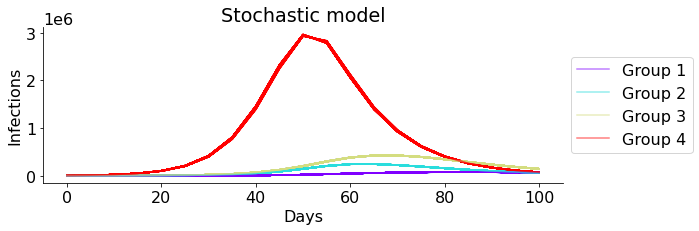

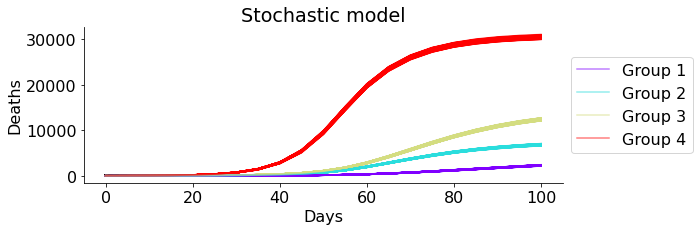

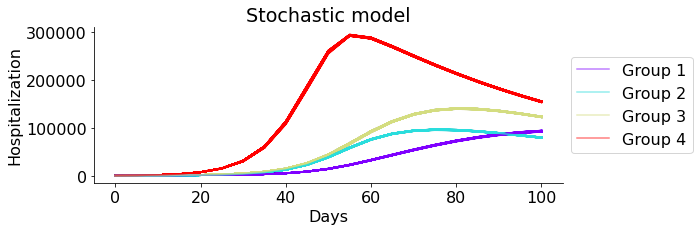

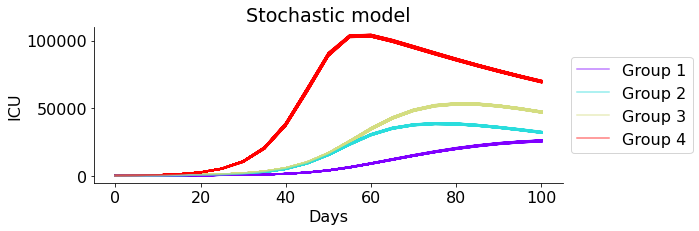

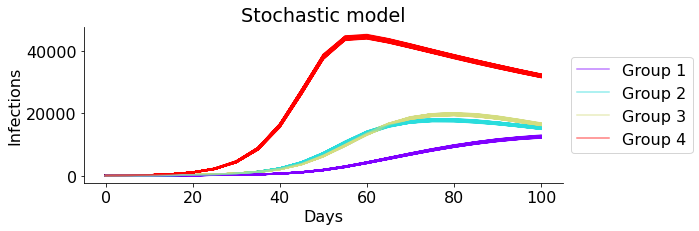

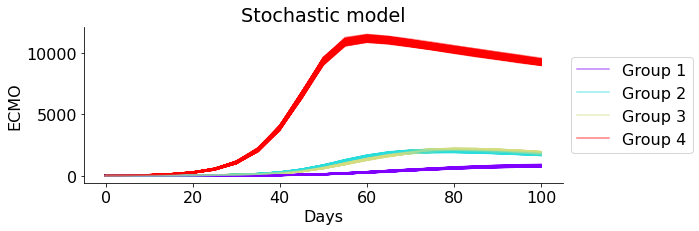

In [234]:
color = cm.rainbow(np.linspace(0, 1, m))

# Infections by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for k in range(n_iter): 
    for i,c in enumerate(color):
        if k == 0: 
            ax.plot(dataset[k].iloc[:,0], dataset[k].iloc[:,2*m+1+2*i]+dataset[k].iloc[:,2*m+2+2*i], c=c, alpha=0.5, label = f'Group {i+1}')
        else: 
            ax.plot(dataset[k].iloc[:,0], dataset[k].iloc[:,2*m+1+2*i]+dataset[k].iloc[:,2*m+2+2*i], c=c, alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('Infections')
# ax.set_ylim(0,1000)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model')
plt.tight_layout()
plt.show()

# Deaths by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for k in range(n_iter): 
    for i,c in enumerate(color):
        if k == 0: 
            ax.plot(dataset[k].iloc[:,0], dataset[k].iloc[:,6*m+1+2*i]+dataset[k].iloc[:,6*m+2+2*i], c=c, alpha=0.5, label = f'Group {i+1}')
        else: 
            ax.plot(dataset[k].iloc[:,0], dataset[k].iloc[:,6*m+1+2*i]+dataset[k].iloc[:,6*m+2+2*i], c=c, alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('Deaths')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model')
plt.tight_layout()
plt.show()

# Hospitalization by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for k in range(n_iter): 
    for i,c in enumerate(color):
        if k == 0: 
            ax.plot(dataset[k].iloc[:,0], dataset[k].iloc[:,8*m+1+i], c=c, alpha=0.5, label = f'Group {i+1}')
        else: 
            ax.plot(dataset[k].iloc[:,0], dataset[k].iloc[:,8*m+1+i], c=c, alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('Hospitalization')
# ax.set_ylim(0,1000)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model')
plt.tight_layout()
plt.show()

# ICU by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for k in range(n_iter): 
    for i,c in enumerate(color):
        if k == 0: 
            ax.plot(dataset[k].iloc[:,0], dataset[k].iloc[:,9*m+1+i], c=c, alpha=0.5, label = f'Group {i+1}')
        else: 
            ax.plot(dataset[k].iloc[:,0], dataset[k].iloc[:,9*m+1+i], c=c, alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('ICU')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model')
plt.tight_layout()
plt.show()

# Vents by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for k in range(n_iter): 
    for i,c in enumerate(color):
        if k == 0: 
            ax.plot(dataset[k].iloc[:,0], dataset[k].iloc[:,10*m+1+i], c=c, alpha=0.5, label = f'Group {i+1}')
        else: 
            ax.plot(dataset[k].iloc[:,0], dataset[k].iloc[:,10*m+1+i], c=c, alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('Infections')
# ax.set_ylim(0,1000)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model')
plt.tight_layout()
plt.show()

# ECMO by group 

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for k in range(n_iter): 
    for i,c in enumerate(color):
        if k == 0: 
            ax.plot(dataset[k].iloc[:,0], dataset[k].iloc[:,11*m+1+i], c=c, alpha=0.5, label = f'Group {i+1}')
        else: 
            ax.plot(dataset[k].iloc[:,0], dataset[k].iloc[:,11*m+1+i], c=c, alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('ECMO')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model')
plt.tight_layout()
plt.show()


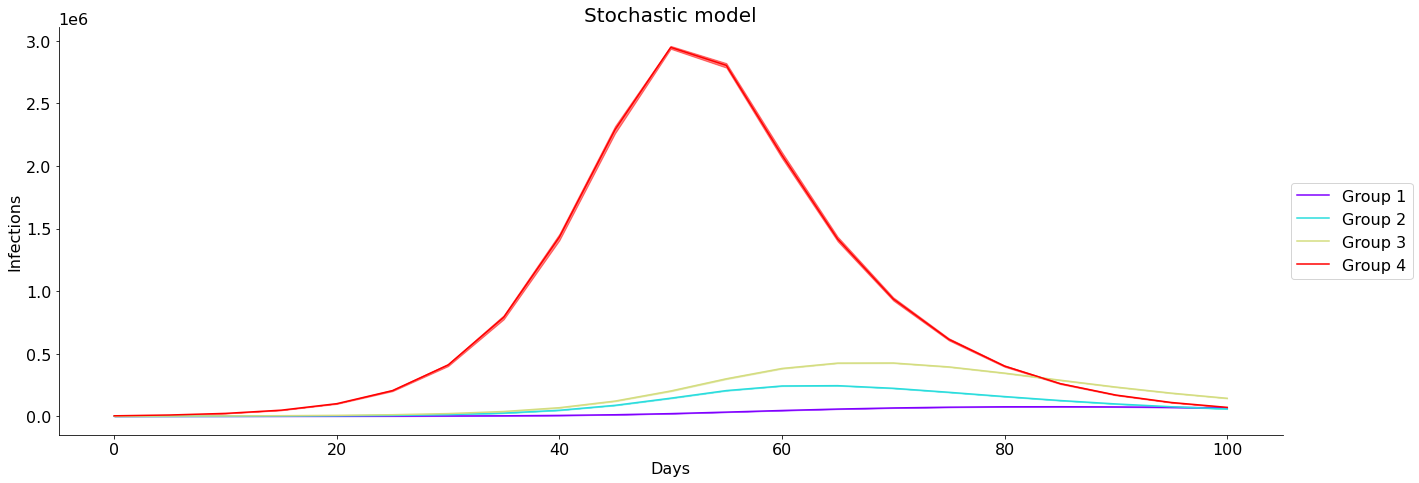

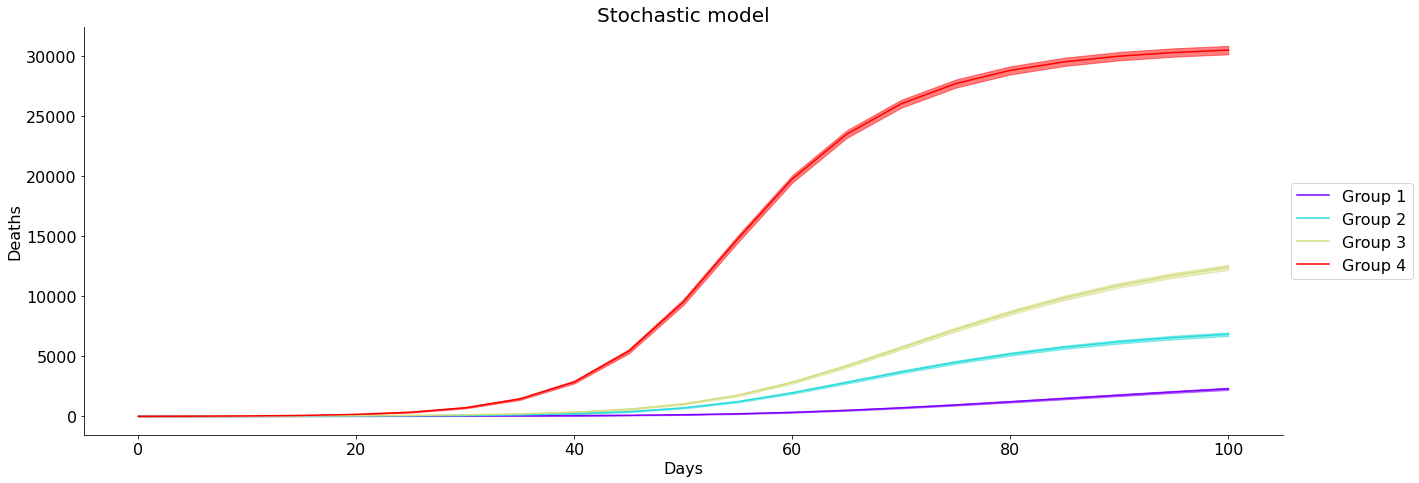

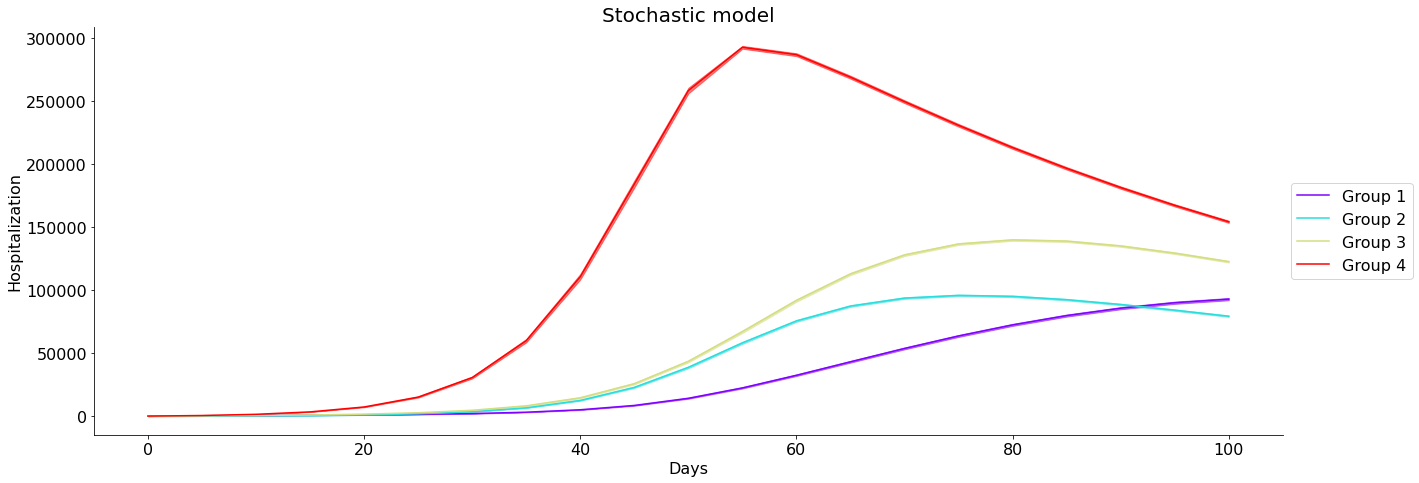

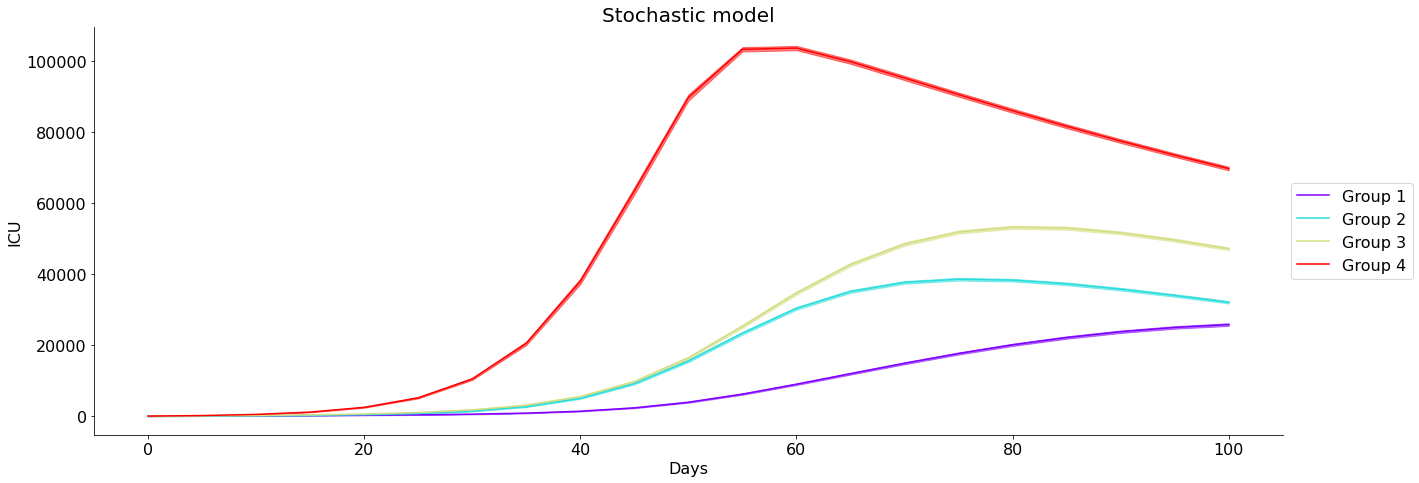

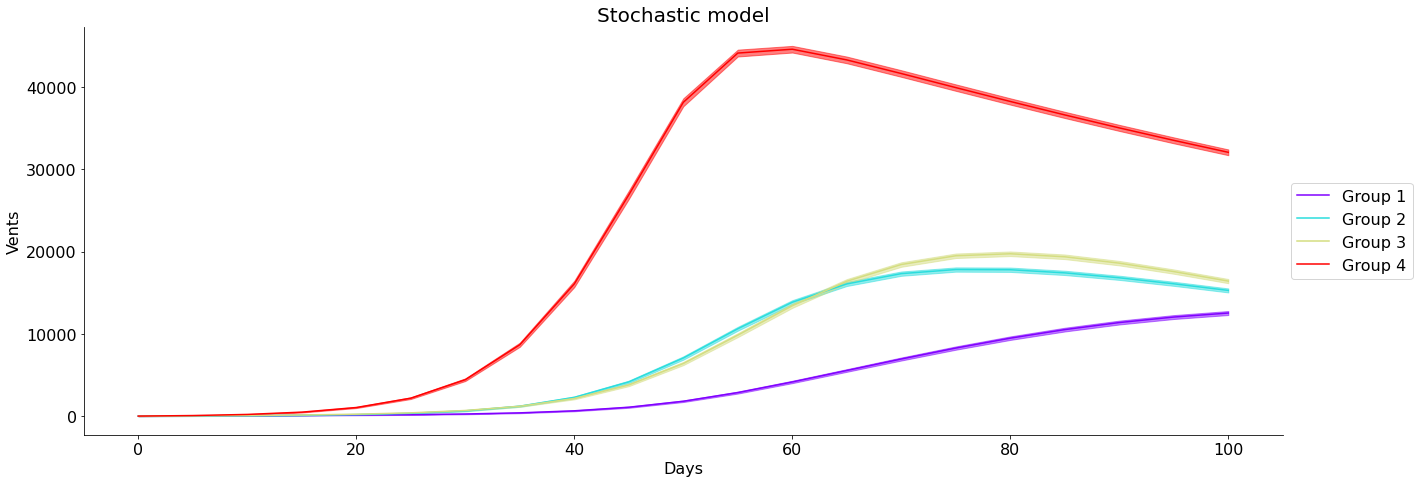

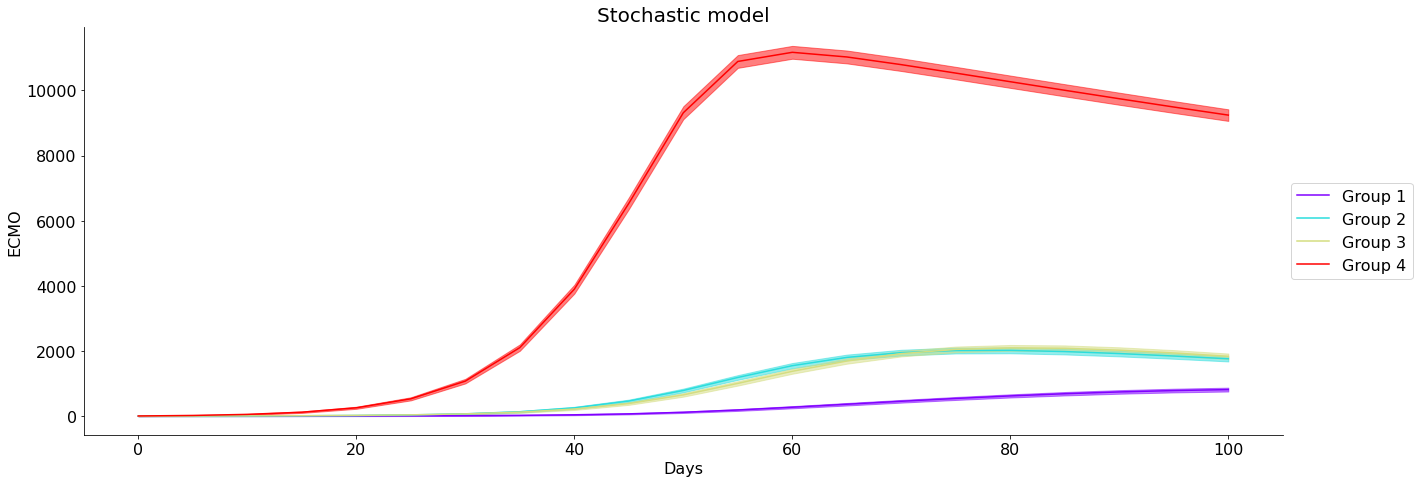

In [235]:
# Means

color = cm.rainbow(np.linspace(0, 1, m))
plt.rcParams['font.size'] = '16'

# Infections by group 

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color):
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,12*m+1+i], c=c, label = f'Group {i+1}')
    plt.fill_between(df_means.iloc[:,0], df_means.iloc[:,12*m+1+i]-1.96*df_std.iloc[:,12*m+1+i], \
                     df_means.iloc[:,12*m+1+i]+1.96*df_std.iloc[:,12*m+1+i], color=c, alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('Infections')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model', fontsize=20)
plt.tight_layout()
plt.show()

# Deaths by group 

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color): 
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,13*m+1+i], c=c, label = f'Group {i+1}')
    plt.fill_between(df_means.iloc[:,0], df_means.iloc[:,13*m+1+i]-1.96*df_std.iloc[:,13*m+1+i], \
                     df_means.iloc[:,13*m+1+i]+1.96*df_std.iloc[:,13*m+1+i], color=c, alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('Deaths')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model', fontsize=20)
plt.tight_layout()
plt.show()


# Hospitalization by group 

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color):
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,8*m+1+i], c=c, label = f'Group {i+1}')
    plt.fill_between(df_means.iloc[:,0], df_means.iloc[:,8*m+1+i]-1.96*df_std.iloc[:,8*m+1+i], \
                     df_means.iloc[:,8*m+1+i]+1.96*df_std.iloc[:,8*m+1+i], color=c, alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('Hospitalization')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model', fontsize=20)
plt.tight_layout()
plt.show()

# ICU by group 

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color): 
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,9*m+1+i], c=c, label = f'Group {i+1}')
    plt.fill_between(df_means.iloc[:,0], df_means.iloc[:,9*m+1+i]-1.96*df_std.iloc[:,9*m+1+i], \
                     df_means.iloc[:,9*m+1+i]+1.96*df_std.iloc[:,9*m+1+i], color=c, alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('ICU')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model', fontsize=20)
plt.tight_layout()
plt.show()

# Vents by group 

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color): 
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,10*m+1+i], c=c, label = f'Group {i+1}')
    plt.fill_between(df_means.iloc[:,0], df_means.iloc[:,10*m+1+i]-1.96*df_std.iloc[:,10*m+1+i], \
                     df_means.iloc[:,10*m+1+i]+1.96*df_std.iloc[:,10*m+1+i], color=c, alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('Vents')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model', fontsize=20)
plt.tight_layout()
plt.show()

# ECMO by group 

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i,c in enumerate(color): 
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,11*m+1+i], c=c, label = f'Group {i+1}')
    plt.fill_between(df_means.iloc[:,0], df_means.iloc[:,11*m+1+i]-1.96*df_std.iloc[:,11*m+1+i], \
                     df_means.iloc[:,11*m+1+i]+1.96*df_std.iloc[:,11*m+1+i], color=c, alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('ECMO')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Stochastic model', fontsize=20)
plt.tight_layout()
plt.show()

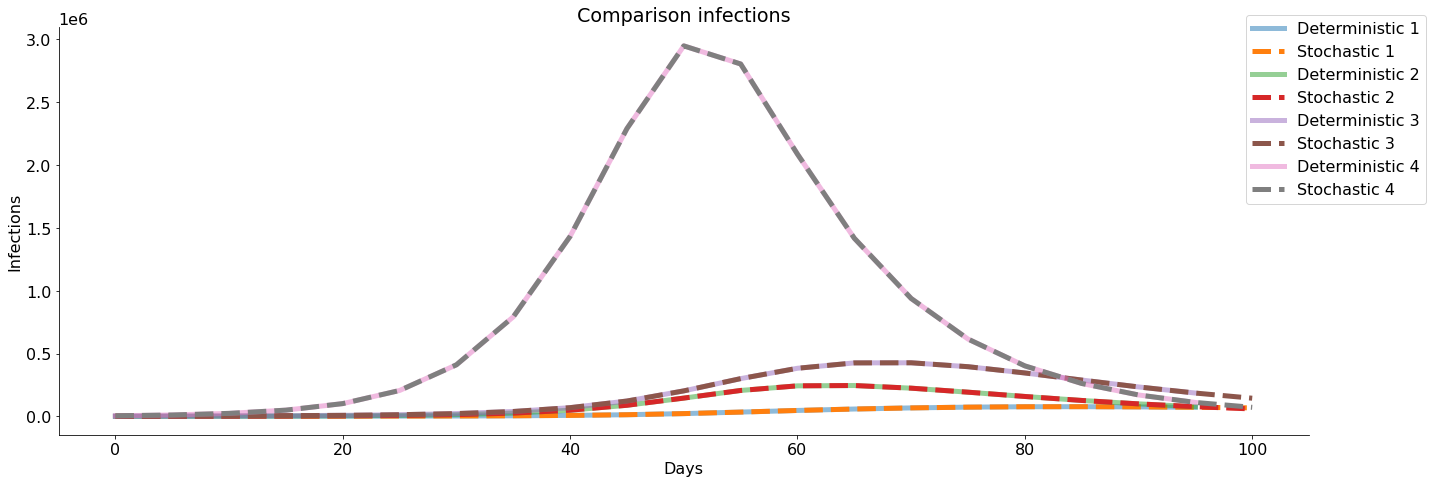

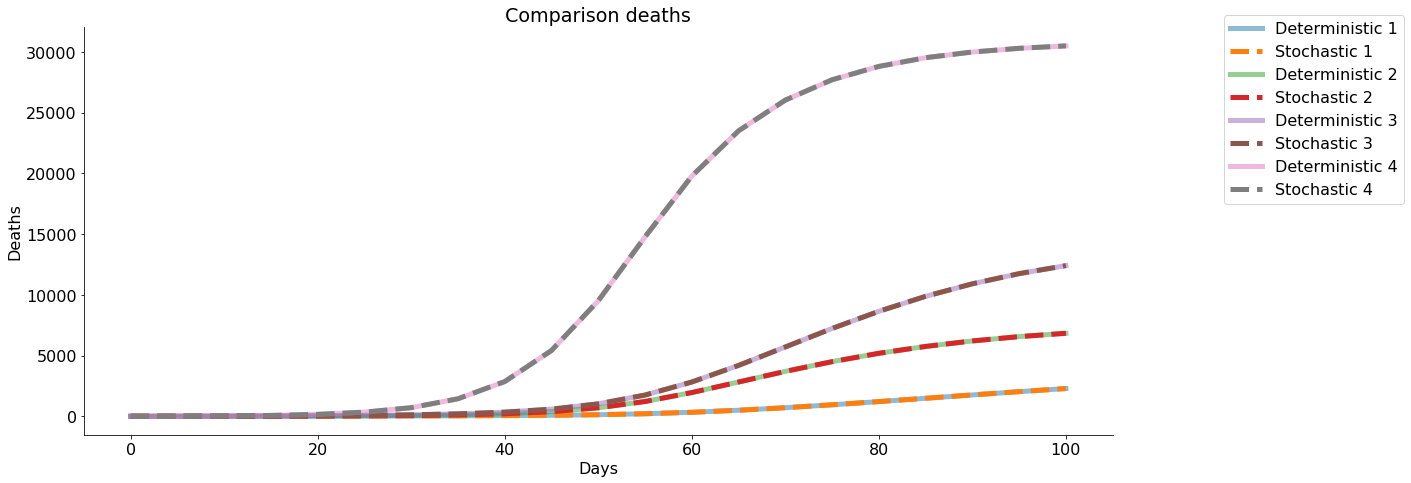

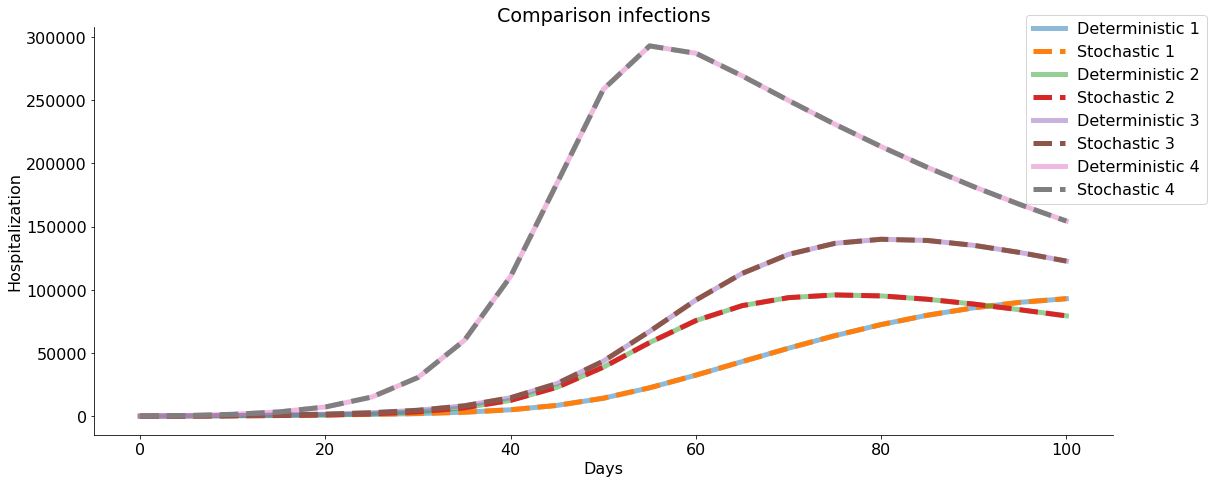

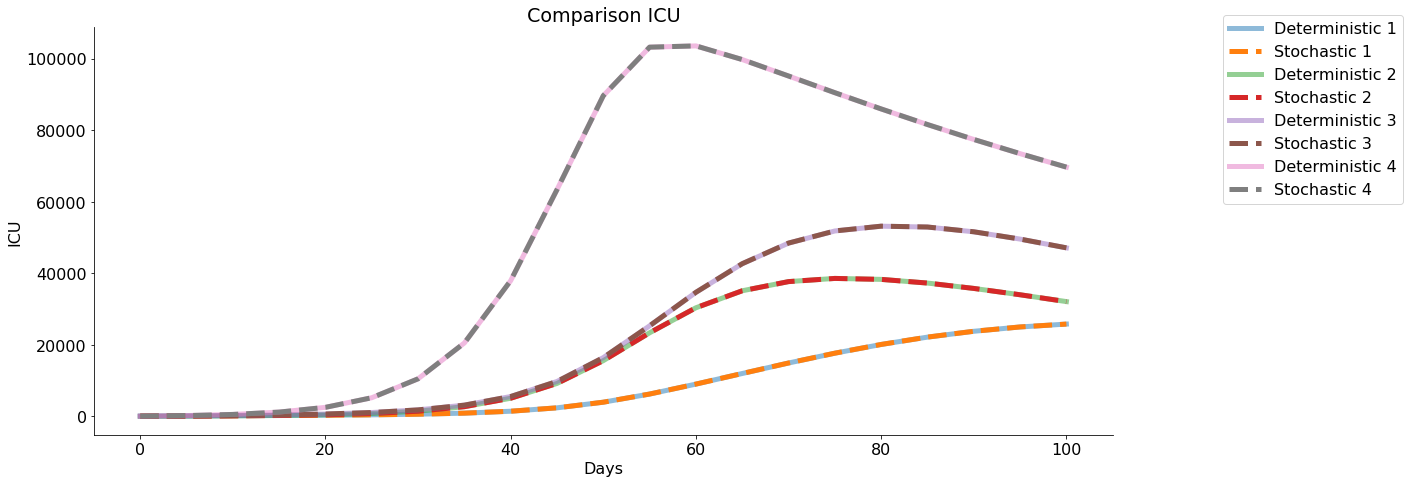

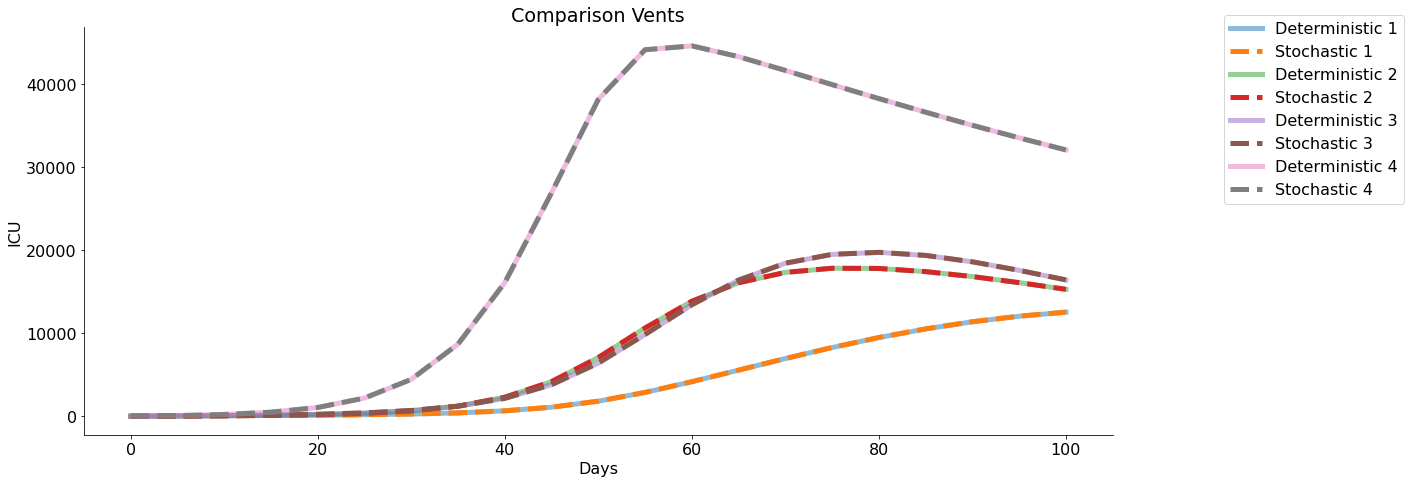

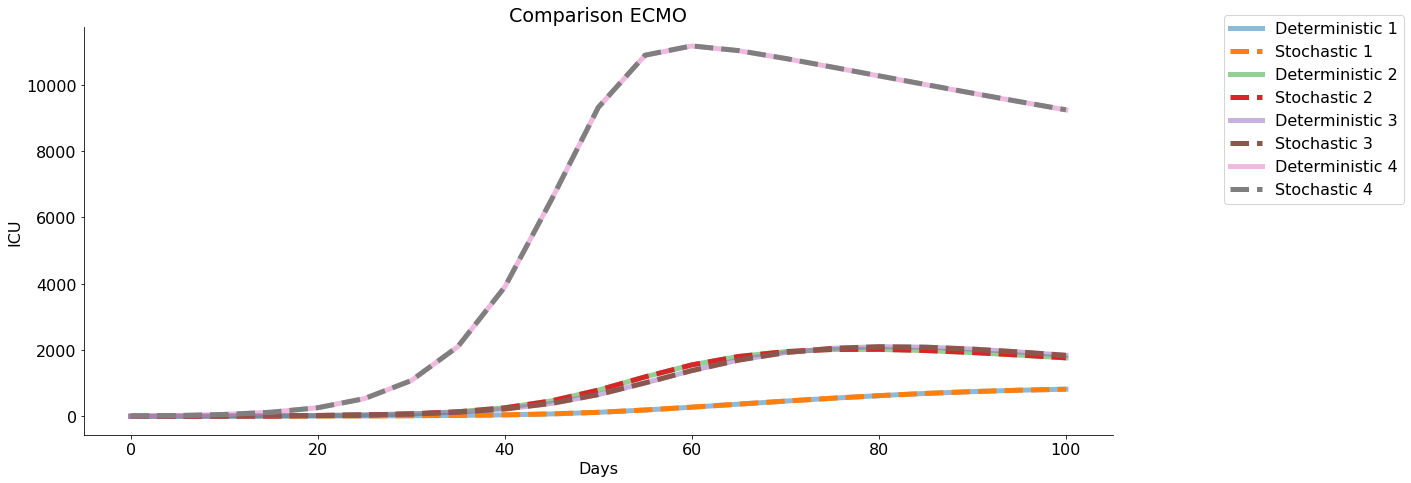

In [236]:
# Infections by group 

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


for i in range(m):
    ax.plot(SIR_det.iloc[0:iterations+1,0], SIR_det.iloc[0:iterations+1,2*m+1+2*i]\
                +SIR_det.iloc[0:iterations,2*m+2+2*i], linewidth = 5, label = f'Deterministic {i+1}', alpha = 0.5)
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,12*m+1+i], linewidth = 5, label = f'Stochastic {i+1}', linestyle = '--')
ax.set_xlabel('Days')
ax.set_ylabel('Infections')
ax.legend(bbox_to_anchor=(1.1, 1.05))

plt.title('Comparison infections')
plt.tight_layout()
plt.show()

# Deaths by group 

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(m): 
    ax.plot(SIR_det.iloc[0:iterations+1,0], SIR_det.iloc[0:iterations+1,6*m+1+2*i]\
                +SIR_det.iloc[0:iterations+1,6*m+2+2*i], linewidth = 5, label = f'Deterministic {i+1}', alpha = 0.5)
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,13*m+1+i], linewidth = 5, label = f'Stochastic {i+1}', linestyle = '--')
ax.set_xlabel('Days')
ax.set_ylabel('Deaths')
ax.legend(bbox_to_anchor=(1.1, 1.05))

plt.title('Comparison deaths')
plt.tight_layout()
plt.show()

# Hospitalization by group 

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(m):
    ax.plot(SIR_det.iloc[0:iterations+1,0], SIR_det.iloc[0:iterations+1,8*m+1+i],\
            linewidth = 5, label = f'Deterministic {i+1}', alpha = 0.5)
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,8*m+1+i], linewidth = 5, label = f'Stochastic {i+1}', linestyle = '--')
ax.set_xlabel('Days')
ax.set_ylabel('Hospitalization')
ax.legend(bbox_to_anchor=(1.1, 1.05))

plt.title('Comparison infections')
plt.tight_layout()
plt.show()

# ICU by group 

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(m):
    ax.plot(SIR_det.iloc[0:iterations+1,0], SIR_det.iloc[0:iterations+1,9*m+1+i],\
            linewidth = 5, label = f'Deterministic {i+1}', alpha = 0.5)
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,9*m+1+i], linewidth = 5, label = f'Stochastic {i+1}', linestyle = '--')
ax.set_xlabel('Days')
ax.set_ylabel('ICU')
ax.legend(bbox_to_anchor=(1.1, 1.05))

plt.title('Comparison ICU')
plt.tight_layout()
plt.show()

# Vents by group 

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(m):
    ax.plot(SIR_det.iloc[0:iterations+1,0], SIR_det.iloc[0:iterations+1,10*m+1+i],\
            linewidth = 5, label = f'Deterministic {i+1}', alpha = 0.5)
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,10*m+1+i], linewidth = 5, label = f'Stochastic {i+1}', linestyle = '--')
ax.set_xlabel('Days')
ax.set_ylabel('ICU')
ax.legend(bbox_to_anchor=(1.1, 1.05))

plt.title('Comparison Vents')
plt.tight_layout()
plt.show()

# ECMO by group 

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(m):
    ax.plot(SIR_det.iloc[0:iterations+1,0], SIR_det.iloc[0:iterations+1,11*m+1+i],\
            linewidth = 5, label = f'Deterministic {i+1}', alpha = 0.5)
    ax.plot(df_means.iloc[:,0], df_means.iloc[:,11*m+1+i], linewidth = 5, label = f'Stochastic {i+1}', linestyle = '--')
ax.set_xlabel('Days')
ax.set_ylabel('ICU')
ax.legend(bbox_to_anchor=(1.1, 1.05))

plt.title('Comparison ECMO')
plt.tight_layout()
plt.show()


In [237]:
n_iter

1000

In [238]:
# plot distribution of infections for stochastic model 
# check if distributions are similar to the excel model (# ventilation...): created the plots
# check deterministc with different parameters: ok 

In [239]:
## Stochastic model: Plot distribution of infections 
label_outcomes = ['Hospitalization', 'ICU', 'Vents', 'ECMO', 'Infections', 'Deaths']
n_outcomes = len(label_outcomes)
outcomes = np.zeros((n_iter, n_outcomes))

for i in range(n_iter): 
    for j in range(n_outcomes): 
        outcomes[i,j] = max(dataset[i].iloc[:,(8+j)*m+1])
    

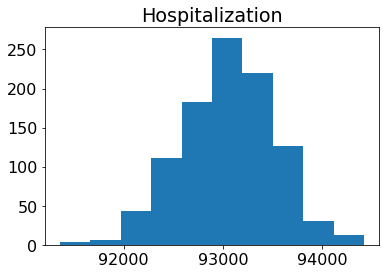

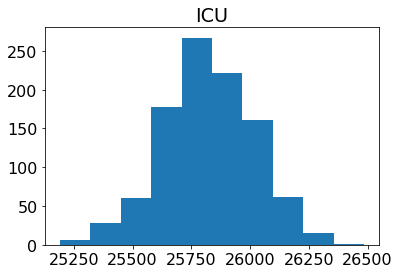

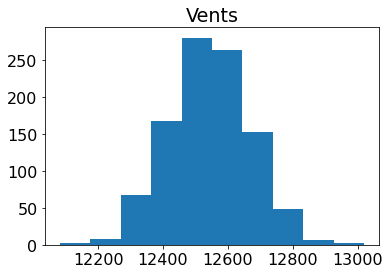

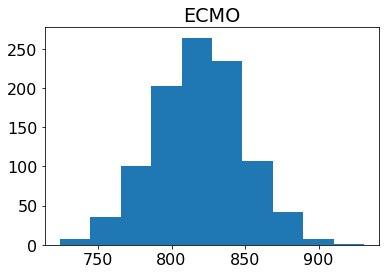

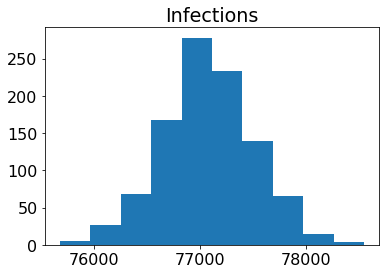

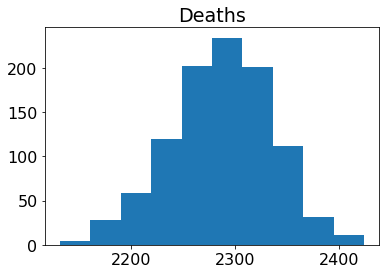

In [240]:
for j in range(n_outcomes): 
    plt.hist(outcomes[:,j])
    plt.title(label_outcomes[j])
    plt.savefig('Output/{}_{}.png'.format(label_outcomes[j],n_iter))
    plt.show()

In [ ]:
# Automate the outcomes? 